## Params, Imports, Read data,

In [1]:
import matplotlib.pyplot as plt
import os, glob
import numpy as np
from tqdm.auto import tqdm
from astropy.io import fits
from astropy.table import Table, vstack, MaskedColumn
from astropy.time import Time, TimeDelta
from astropy import units as u
import pandas as pd
import pickle
import json
import seaborn as sns
import george
from george import kernels
from scipy.optimize import minimize
from matplotlib.lines import Line2D
from scipy.stats import iqr
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from collections import defaultdict
from matplotlib.colors import Normalize
from matplotlib.cm import viridis
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import re
import time

import logging
import multiprocessing as mp
import concurrent.futures
import gc  # For garbage collection

import xgboost as xgb

# Use get_cmap from pyplot
get_cmap = plt.get_cmap

# Configure logging
logging.basicConfig(
    filename='data_conversion_debug.log',  # Log file name
    filemode='w',                           # Overwrite the log file each run
    level=logging.DEBUG,                    # Capture all levels of logs
    format='%(asctime)s - %(levelname)s - %(message)s'  # Log format
)

In [8]:
# Define LSST band colors and effective wavelengths (positions for data points along wavelength direction)

lsst_bands = {
    "u": 3670.69,
    "g": 4826.85,
    "r": 6223.24,
    "i": 7545.98,
    "z": 8590.90,
    "Y": 9710.28
}


bands = ["u", "g", "r", "i", "z", "Y"]

band_colors = {'u': 'blue', 'g': 'green', 'r': 'red', 'i': 'purple', 'z': 'brown', 'Y': 'yellow'}


In [9]:
def read_elasticc_file(filename):
    if '_PHOT' in filename:
        headname = filename.replace('_PHOT', '_HEAD')
    else:
        headname = filename
        filename = filename.replace('_HEAD', '_PHOT')

    # Debug prints to verify paths
    #print(f"reading phot file: {filename}")
    print(f"reading head file: {headname}")
    
    if not os.path.exists(filename):
        raise FileNotFoundError(f"File not found: {filename}")
    if not os.path.exists(headname):
        raise FileNotFoundError(f"File not found: {headname}")

    table = Table.read(filename)
    head = Table.read(headname)

    # Sanitize the data
    for _ in table:
        _['BAND'] = _['BAND'].strip()

    head['SNID'] = np.int64(head['SNID'])
    
    # Sanity check 
    if np.sum(table['MJD'] < 0) != len(head):
        print(filename, 'is broken:', np.sum(table['MJD'] < 0), '!=', len(head))
        
    # Measured mag and magerr - simulated one is in SIM_MAGOBS
    table['mag'] = np.nan
    table['magerr'] = np.nan
    idx = table['FLUXCAL'] > 0
    
    table['mag'][idx] = 27.5 - 2.5 * np.log10(table['FLUXCAL'][idx])
    table['magerr'][idx] = 2.5 / np.log(10) * table['FLUXCALERR'][idx] / table['FLUXCAL'][idx]
    
    # Augment table with SNID (light curve id) from head
    table['SNID'] = 0
    
    idx = np.where(table['MJD'] < 0)[0]
    idx = np.hstack((np.array([0]), idx))

    for i in range(1, len(idx)):
        i0, i1 = idx[i - 1], idx[i]
        table['SNID'][i0:i1] = head['SNID'][i - 1]
    
    table = table[table['MJD'] > 0]

    return table, head


## FUNCTIONS 

In [10]:
def get_snid_head_sub(table, head):
    snids = np.unique(table['SNID'])
    shead_list = [head[head['SNID'] == snid] for snid in snids]
    sub_list = [table[table['SNID'] == snid] for snid in snids]
    return snids, shead_list, sub_list


### compute GP

In [11]:
def try_optimization(gp, snid, neg_ln_like, grad_neg_ln_like, initial_guess, retries=3):
    best_result = None
    for attempt in range(retries):
        result = minimize(neg_ln_like, initial_guess, jac=grad_neg_ln_like, method='L-BFGS-B')
        if (best_result is None 
            or (result.success and not best_result.success)
            or (result.success == best_result.success and result.fun < best_result.fun)):
            best_result = result

        if result.success:
            break
        else:
            # Slightly perturb the initial guess for the next attempt
            initial_guess += np.random.normal(0, 1e-2, size=initial_guess.shape)
    
    if best_result is None or not best_result.success:
        print(f"All optimization attempts failed for SNID {snid}")
        gp.set_parameter_vector(initial_guess)  # Use the best guess available
    else:
        gp.set_parameter_vector(best_result.x)

In [12]:
def compute_gp(sub, snid, verbose=False):
    try:
        # Ensure inputs are numpy arrays with appropriate dtype
        t = np.array(sub['MJD'], dtype=float)
        flux = np.array(sub['FLUXCAL'], dtype=float)
        fluxerr = np.array(sub['FLUXCALERR'], dtype=float)
        band = np.array([lsst_bands.get(b) for b in sub['BAND']], dtype=float)
        
        # 2D positions of data points (time and wavelength)
        x = np.vstack([t, band]).T
        
        # Clean the data: remove rows with NaNs, infs, and non-positive flux values
        mask = np.isfinite(flux) & np.isfinite(fluxerr) & np.all(np.isfinite(x), axis=1) & (flux > 0)
        x = x[mask]
        flux = flux[mask]
        fluxerr = fluxerr[mask]

        if len(flux) < 5:  # Ensure there are enough data points
            raise ValueError("Not enough data points to perform GP fitting.")
        
        signal_to_noises = np.abs(flux) / np.sqrt(fluxerr ** 2 + (1e-2 * np.max(flux)) ** 2)
        scale = np.abs(flux[np.argmax(signal_to_noises)])

        # Define the kernel
        kernel = (0.5 * scale) ** 2 * george.kernels.Matern32Kernel([100 ** 2, 6000 ** 2], ndim=2)
        
        # Define the GP model with HODLR solver and white noise
        gp = george.GP(kernel, solver=george.HODLRSolver)
        
        # Compute the GP
        gp.compute(x, fluxerr)
        
        # Define the negative log likelihood and its gradient
        def neg_ln_like(p):
            gp.set_parameter_vector(p)
            return -gp.log_likelihood(flux)
        
        def grad_neg_ln_like(p):
            gp.set_parameter_vector(p)
            return -gp.grad_log_likelihood(flux)
        
        # Attempt optimization with multiple initial guesses
        initial_guess = gp.get_parameter_vector()
        try_optimization(gp, snid, neg_ln_like, grad_neg_ln_like, initial_guess, retries=3)
        
        # Return the GP, flux, data points, and final parameters
        return gp, flux, x, gp.get_parameter_vector()

    except (ValueError, np.linalg.LinAlgError, Exception) as e:
        print(f"GP optimization failed for SNID {snid}: {e}")
        return None, None, None, None  # Return None values


### peak and rise/fade estimation 

In [13]:
def find_peak_and_calculate_times(gp, sub, flux, band1='g', band2='r', peak_threshold=2.512):
    """
    Find the peak using Gaussian Process predictions for two input bands (band1 and band2).
    Then calculate the rise and fade times relative to the peak for each band.
    """
    
    # Generate MJD values for predictions
    t_min, t_max = sub['MJD'].min(), sub['MJD'].max()

    # Variables to hold peak information for both bands
    peak_mjd_band1, peak_flux_band1, rise_time_band1, fade_time_band1 = None, None, None, None
    peak_mjd_band2, peak_flux_band2, rise_time_band2, fade_time_band2 = None, None, None, None

    # Loop over the two input bands (band1 and band2)
    for band in [band1, band2]:
        mjd_for_pred = np.linspace(t_min - 50, t_max + 75, 1000)
        wavelength = lsst_bands[band]
        x_pred = np.vstack([mjd_for_pred, wavelength * np.ones_like(mjd_for_pred)]).T

        # Predict flux at these times using the GP model
        mean_pred, _ = gp.predict(flux, x_pred, return_var=True)

        # Find the time of peak flux
        peak_flux_idx = np.argmax(mean_pred)
        peak_mjd = mjd_for_pred[peak_flux_idx]
        peak_flux = mean_pred[peak_flux_idx]

        # Calculate rise and fade times
        one_flux_fainter = peak_flux / peak_threshold  # Threshold flux for 1 mag fainter

        # Rise time: time it took to rise from the faint threshold to the peak
        rise_time = None
        try:
            rise_time_idx = np.where(mean_pred[:peak_flux_idx] <= one_flux_fainter)[0]
            if len(rise_time_idx) > 0:
                rise_time = peak_mjd - mjd_for_pred[rise_time_idx[-1]]
        except IndexError:
            rise_time = None  # If no valid rise time found

        # Fade time: time it takes to decay from peak to the faint threshold
        fade_time = None
        try:
            fade_time_idx = np.where(mean_pred[peak_flux_idx:] <= one_flux_fainter)[0]
            if len(fade_time_idx) > 0:
                fade_time = mjd_for_pred[peak_flux_idx + fade_time_idx[0]] - peak_mjd
        except IndexError:
            fade_time = None  # If no valid fade time found

        # Store results for the respective band
        if band == band1:
            peak_mjd_band1, peak_flux_band1, rise_time_band1, fade_time_band1 = peak_mjd, peak_flux, rise_time, fade_time
        elif band == band2:
            peak_mjd_band2, peak_flux_band2, rise_time_band2, fade_time_band2 = peak_mjd, peak_flux, rise_time, fade_time

    return (peak_mjd_band1, peak_flux_band1, rise_time_band1, fade_time_band1, 
            peak_mjd_band2, peak_flux_band2, rise_time_band2, fade_time_band2)


### color estimation

In [14]:
def calc_color(gp, flux, x, x1, band1, band2):
    x_band1 = np.vstack([x1, lsst_bands[band1] * np.ones_like(x1)]).T
    x_band2 = np.vstack([x1, lsst_bands[band2] * np.ones_like(x1)]).T

    # Predict fluxes and their variances for both bands
    flux_pred_band1, fluxvar_band1 = gp.predict(flux, x_band1, return_var=True)
    flux_pred_band2, fluxvar_band2 = gp.predict(flux, x_band2, return_var=True)

    # Ensure positive flux predictions by clipping at a small positive value
    flux_pred_band1_clipped = np.clip(flux_pred_band1, 1e-10, None)
    flux_pred_band2_clipped = np.clip(flux_pred_band2, 1e-10, None)

    # Ensure that variances are non-negative
    fluxvar_band1_clipped = np.clip(fluxvar_band1, 0, None)
    fluxvar_band2_clipped = np.clip(fluxvar_band2, 0, None)

    # Calculate magnitudes from fluxes
    mag_band1 = -2.5 * np.log10(flux_pred_band1_clipped)
    mag_band2 = -2.5 * np.log10(flux_pred_band2_clipped)
    
    # Calculate errors in magnitudes
    with np.errstate(invalid='ignore', divide='ignore'):
        magerr_band1 = 2.5 / np.log(10) * (np.sqrt(fluxvar_band1_clipped) / flux_pred_band1_clipped)
        magerr_band2 = 2.5 / np.log(10) * (np.sqrt(fluxvar_band2_clipped) / flux_pred_band2_clipped)

    # Calculate color as the difference in magnitudes
    color = mag_band1 - mag_band2
    
    # Calculate the error in color
    color_err = np.sqrt(magerr_band1**2 + magerr_band2**2)

    # Create a mask to select only non-NaN and finite elements
    valid_mask = np.isfinite(color) & np.isfinite(color_err)

    # Apply the mask to color, color_err arrays, and x1
    color = color[valid_mask]
    color_err = color_err[valid_mask]
    x1 = x1[valid_mask]

    return x1, color, color_err


### mean color and color evolution

In [15]:
def weighted_mean_std(value, error, min_error=1e-6):
    """
    Calculates the weighted mean and weighted standard deviation.

    Parameters:
        value (array-like): Data values.
        error (array-like): Error values corresponding to the data.
        min_error (float): Minimum allowable error to prevent division by zero.

    Returns:
        tuple: (weighted_mean, weighted_std)
    """
    # Replace zero or negative errors with min_error
    error_safe = np.where(error > 0, error, min_error)
    
    # Calculate weights
    weight = 1 / error_safe**2
    
    # Handle cases where weights might still be invalid (e.g., due to overflow)
    weight = np.where(np.isfinite(weight), weight, 0)
    
    # Calculate the sum of weights
    sum_weights = np.sum(weight)
    
    if sum_weights == 0:
        # If all weights are zero, return NaN
        weighted_mean = np.nan
        weighted_std = np.nan
    else:
        # Calculate weighted mean
        weighted_mean = np.sum(value * weight) / sum_weights
        
        # Calculate weighted standard deviation
        weighted_std = np.sqrt(1 / sum_weights)
    
    return weighted_mean, weighted_std


In [16]:
def calc_mean_colors_and_slope(sub, gp, flux, x, band1, band2, rise_time, fade_time, t_peak):
    """
    Calculate mean colors, slopes, and plot color evolution for a given SNID using rise and fade times.
    Fallback to original logic if rise_time or fade_time is not available.
    """
    
    # Fallback to default rise_time and fade_time if not valid
    calc_rise_time = 50 if rise_time is None or not np.isfinite(rise_time) else rise_time
    calc_fade_time = 75 if fade_time is None or not np.isfinite(fade_time) else fade_time

    ### Pre-peak calculations using the rise time or default window
    try:
        indices_pre_peak = ((sub['BAND'] == band1) | (sub['BAND'] == band2)) & \
                           (sub['MJD'] >= t_peak - calc_rise_time) & (sub['MJD'] <= t_peak)
        mjd_pre_peak = sub['MJD'][indices_pre_peak]

        # Calculate color and filter valid data
        x_pre_peak, color_pre_peak, color_err_pre_peak = calc_color(gp, flux, x, mjd_pre_peak, band1, band2)

        # Ensure we only apply np.isfinite() to numeric data
        mask_pre = np.isfinite(x_pre_peak) & np.isfinite(color_pre_peak) & (color_err_pre_peak < 1)

        # Apply mask to filter out invalid data
        x_pre_peak, color_pre_peak, color_err_pre_peak = x_pre_peak[mask_pre], color_pre_peak[mask_pre], color_err_pre_peak[mask_pre]

    except Exception as e:
        # If pre-peak data fails, set all pre-peak values to None
        x_pre_peak, color_pre_peak, color_err_pre_peak = None, None, None

    ### Post-peak calculations using the fade time or default window
    try:
        indices_post_peak = ((sub['BAND'] == band1) | (sub['BAND'] == band2)) & \
                            (sub['MJD'] > t_peak) & (sub['MJD'] <= t_peak + calc_fade_time)
        mjd_post_peak = sub['MJD'][indices_post_peak]

        # Calculate color and filter valid data
        x_post_peak, color_post_peak, color_err_post_peak = calc_color(gp, flux, x, mjd_post_peak, band1, band2)

        # Ensure we only apply np.isfinite() to numeric data
        mask_post = np.isfinite(x_post_peak) & np.isfinite(color_post_peak) & (color_err_post_peak < 1)

        # Apply mask to filter out invalid data
        x_post_peak, color_post_peak, color_err_post_peak = x_post_peak[mask_post], color_post_peak[mask_post], color_err_post_peak[mask_post]

    except Exception as e:
        # If post-peak data fails, set all post-peak values to None
        x_post_peak, color_post_peak, color_err_post_peak = None, None, None

    ### Calculate weighted mean for pre-peak and post-peak colors
    mean_color_pre_peak, std_err_mean_color_pre_peak = None, None
    if color_pre_peak is not None and len(color_pre_peak) > 0:
        mean_color_pre_peak, std_err_mean_color_pre_peak = weighted_mean_std(color_pre_peak, color_err_pre_peak)

    mean_color_post_peak, std_err_mean_color_post_peak = None, None
    if color_post_peak is not None and len(color_post_peak) > 0:
        mean_color_post_peak, std_err_mean_color_post_peak = weighted_mean_std(color_post_peak, color_err_post_peak)

    ### Calculate slopes for pre-peak and post-peak
    slope_pre_peak, slope_err_pre_peak = None, None
    if x_pre_peak is not None and len(x_pre_peak) >= 2:
        try:
            # Replace zero or very small color_err_pre_peak with a minimum threshold
            color_err_pre_peak_safe = np.where(color_err_pre_peak > 0, color_err_pre_peak, 1e-6)
            
            # Calculate weights safely
            weights_pre = 1 / color_err_pre_peak_safe**2
            weights_pre = np.where(np.isfinite(weights_pre), weights_pre, 0)
            
            # Check if sum of weights is zero
            if np.sum(weights_pre) == 0:
                slope_pre_peak, slope_err_pre_peak = np.nan, np.nan
            else:
                p_pre_peak, cov_pre_peak = np.polyfit(
                    x_pre_peak, color_pre_peak, 1, w=weights_pre, cov=True
                )
                slope_pre_peak, _ = p_pre_peak
                slope_err_pre_peak = np.sqrt(cov_pre_peak[0, 0])  # Standard error of the slope
        except Exception as e:
            slope_pre_peak, slope_err_pre_peak = np.nan, np.nan

    slope_post_peak, slope_err_post_peak = None, None
    if x_post_peak is not None and len(x_post_peak) >= 2:
        try:
            # Replace zero or very small color_err_post_peak with a minimum threshold
            color_err_post_peak_safe = np.where(color_err_post_peak > 0, color_err_post_peak, 1e-6)
            
            # Calculate weights safely
            weights_post = 1 / color_err_post_peak_safe**2
            weights_post = np.where(np.isfinite(weights_post), weights_post, 0)
            
            # Check if sum of weights is zero
            if np.sum(weights_post) == 0:
                slope_post_peak, slope_err_post_peak = np.nan, np.nan
            else:
                p_post_peak, cov_post_peak = np.polyfit(
                    x_post_peak, color_post_peak, 1, w=weights_post, cov=True
                )
                slope_post_peak, _ = p_post_peak
                slope_err_post_peak = np.sqrt(cov_post_peak[0, 0])  # Standard error of the slope
        except Exception as e:
            slope_post_peak, slope_err_post_peak = np.nan, np.nan

    return (
        mean_color_pre_peak, std_err_mean_color_pre_peak, slope_pre_peak, slope_err_pre_peak,
        mean_color_post_peak, std_err_mean_color_post_peak, slope_post_peak, slope_err_post_peak
    )


## MAIN PROCESSING LOOP

In [17]:
print(os.getcwd())


/home/bhardwaj/notebooksLSST/tdes-fzu


### multiprocessing

In [ ]:
# Intermediate save function for results (thread-safe)
def save_intermediate_results(data, filename):
    if data:
        print(f"Saving intermediate results to {filename}...")
        df = pd.DataFrame(data)
        # Use a lock to prevent write conflicts
        with open(filename, 'a') as f:
            df.to_csv(f, header=f.tell()==0, index=False)
        print(f"Saved {len(data)} entries.")
    else:
        print(f"No data to save in {filename}.")

# Intermediate save function for errors (thread-safe)
def save_intermediate_errors(errors, filename):
    if errors:
        print(f"Saving intermediate error log to {filename}...")
        df = pd.DataFrame(errors, columns=['SNID', 'Error'])
        # Use a lock to prevent write conflicts
        with open(filename, 'a') as f:
            df.to_csv(f, header=f.tell()==0, index=False)
        print(f"Saved {len(errors)} errors.")
    else:
        print(f"No errors to save in {filename}.")

In [ ]:
# Function to read data for a specific SNID from HDF5
def read_data_for_snid(hdf5_filename, snid):
    with pd.HDFStore(hdf5_filename, 'r') as store:
        # Query the photometry data for the specific SNID
        df_sub = store.select('photometry', where='SNID == snid')
        # Get the header data for the SNID
        df_shead = store.select('header', where='SNID == snid')

    # Convert back to Astropy Tables
    sub = Table.from_pandas(df_sub)
    shead = Table.from_pandas(df_shead)
    return sub, shead

    # Convert back to Astropy Tables 
    if df_sub.empty:
        logging.warning(f"No photometry data found for SNID {snid} in {hdf5_filename}.")
        sub = None
    else:
        sub = Table.from_pandas(df_sub)

    if df_shead.empty:
        logging.warning(f"No header data found for SNID {snid} in {hdf5_filename}.")
        shead = None
    else:
        shead = Table.from_pandas(df_shead)

    return sub, shead


In [ ]:
def process_snid(args):
    """
    Processes a single SNID: reads data, performs computations, and returns results or errors.

    Parameters:
    - args (tuple): Contains (snid, hdf5_filename, object_type)

    Returns:
    - tuple: (entry_dict, error_tuple)
    """
    snid, hdf5_filename, object_type = args
    try:
        start_time = time.time()
        # Read the data for the specific SNID from the HDF5 file
        sub, shead = read_data_for_snid(hdf5_filename, snid)

        if shead is None or len(shead) == 0:
            raise ValueError(f"No header data found for SNID {snid}")

        if 'PEAKMJD' not in shead.colnames:
            raise ValueError(f"'PEAKMJD' is missing in 'shead' for SNID {snid}")

        # Compute SNR of each data point
        sub['SNR'] = sub['FLUXCAL'] / sub['FLUXCALERR']

        # DETECTION CHECK: pass only if there are at least 3 points with SNR > 5 and flux > 50 in any bands
        snr_flux_mask = ((sub['SNR'] > 5) & (sub['FLUXCAL'] > 100)).sum() >= 3
        if not snr_flux_mask:
            return None, (snid, "Failed detection check")

        # Compute the Gaussian Process (GP)
        gp, flux, x, hyperparameters = compute_gp(sub, snid)
        if gp is None:
            return None, (snid, "GP optimization failure")

        # Find the peak and calculate rise and fade times for both band1 (g) and band2 (r)
        peak_mjd_band1, peak_flux_band1, rise_time_band1, fade_time_band1, \
        peak_mjd_band2, peak_flux_band2, rise_time_band2, fade_time_band2 = \
            find_peak_and_calculate_times(gp, sub, flux, 'g', 'r')

        if peak_mjd_band1 is None or peak_mjd_band2 is None:
            return None, (snid, "Peak finding failure")

        # Calculate mean colors and slopes using the peak info from band1 (g) for g-r
        mean_color_pre_peak_gr, std_err_mean_color_pre_peak_gr, slope_pre_peak_gr, slope_err_pre_peak_gr, \
        mean_color_post_peak_gr, std_err_mean_color_post_peak_gr, slope_post_peak_gr, slope_err_post_peak_gr = \
            calc_mean_colors_and_slope(sub, gp, flux, x, 'g', 'r', rise_time_band1, fade_time_band1, peak_mjd_band1)

        # Calculate mean colors and slopes using the peak info from band2 (r) for r-i
        mean_color_pre_peak_ri, std_err_mean_color_pre_peak_ri, slope_pre_peak_ri, slope_err_pre_peak_ri, \
        mean_color_post_peak_ri, std_err_mean_color_post_peak_ri, slope_post_peak_ri, slope_err_post_peak_ri = \
            calc_mean_colors_and_slope(sub, gp, flux, x, 'r', 'i', rise_time_band1, fade_time_band1, peak_mjd_band1)

        # Create dictionary entry with all relevant values
        entry = {
            'SNID': snid,
            'Object_Type': object_type,
            'Amplitude': hyperparameters[0],
            'LengthScale_Time': hyperparameters[1],
            'LengthScale_Wavelength': hyperparameters[2],
            'Rise_Time': rise_time_band1,
            'Fade_Time': fade_time_band1,
            'TruePeakMJD': shead['PEAKMJD'][0],
            'peak_time_MJD': peak_mjd_band1,

            # g-r colors and slopes
            'Mean_Color_Pre_Peak_gr': mean_color_pre_peak_gr,
            'Pre_Peak_Color_err_gr': std_err_mean_color_pre_peak_gr,
            'Mean_Color_Post_Peak_gr': mean_color_post_peak_gr,
            'Post_Peak_Color_err_gr': std_err_mean_color_post_peak_gr,
            'Slope_Pre_Peak_gr': slope_pre_peak_gr,
            'Slope_Err_Pre_Peak_gr': slope_err_pre_peak_gr,
            'Slope_Post_Peak_gr': slope_post_peak_gr,
            'Slope_Err_Post_Peak_gr': slope_err_post_peak_gr,

            # r-i colors and slopes
            'Mean_Color_Pre_Peak_ri': mean_color_pre_peak_ri,
            'Pre_Peak_Color_err_ri': std_err_mean_color_pre_peak_ri,
            'Mean_Color_Post_Peak_ri': mean_color_post_peak_ri,
            'Post_Peak_Color_err_ri': std_err_mean_color_post_peak_ri,
            'Slope_Pre_Peak_ri': slope_pre_peak_ri,
            'Slope_Err_Pre_Peak_ri': slope_err_pre_peak_ri,
            'Slope_Post_Peak_ri': slope_post_peak_ri,
            'Slope_Err_Post_Peak_ri': slope_err_post_peak_ri,
        }

        # Clear variables to free memory
        del gp, flux, x, hyperparameters, sub, shead
        gc.collect()  # Call garbage collector

        elapsed_time = time.time() - start_time
        logging.info(f"Processed SNID {snid} in {elapsed_time:.2f} seconds")

        return entry, None

    except Exception as e:
        logging.error(f"Error processing SNID {snid}: {e}")
        return None, (snid, str(e))
        

In [ ]:
def process_file(hdf5_filename, object_type, intermediate_results_file, error_log_file, max_workers=64, task_timeout=10):
    """
    Processes a single HDF5 file: reads SNIDs, processes them in batches using concurrent.futures with timeouts.

    Parameters:
        hdf5_filename (str): Path to the HDF5 file.
        object_type (str): The object type (e.g., 'SNIa-SALT3').
        intermediate_results_file (str): Path to the intermediate results CSV file.
        error_log_file (str): Path to the error log CSV file.
        max_workers (int): Maximum number of worker processes.
        task_timeout (int): Timeout in seconds for each SNID processing task.
    """
    print(f"Processing file {hdf5_filename} for object type {object_type}")
    batch_size = 500  # Adjust as needed

    try:
        # Read the list of SNIDs from the HDF5 file
        with pd.HDFStore(hdf5_filename, 'r') as store:
            snid_series = store.select_column('header', 'SNID')
            snids = snid_series.unique()
        print(f"Found {len(snids)} SNIDs in the file {hdf5_filename}.")

        num_snids = len(snids)
        num_batches = (num_snids + batch_size - 1) // batch_size

        for batch_num in range(num_batches):
            batch_start = batch_num * batch_size
            batch_end = min((batch_num + 1) * batch_size, num_snids)
            batch_snids = snids[batch_start:batch_end]

            print(f"Processing batch {batch_num + 1}/{num_batches} with {len(batch_snids)} SNIDs.")

            # Prepare arguments for processing
            args_list = [(snid, hdf5_filename, object_type) for snid in batch_snids]

            # Initialize lists to collect results and errors
            entries = []
            errors = []

            # Use ProcessPoolExecutor for concurrent processing with timeouts
            with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
                # Submit all tasks to the executor
                future_to_snid = {executor.submit(process_snid, args): args[0] for args in args_list}

                for future in concurrent.futures.as_completed(future_to_snid):
                    snid = future_to_snid[future]
                    try:
                        # Attempt to get the result within the specified timeout
                        entry, error = future.result(timeout=task_timeout)
                        if entry is not None:
                            entries.append(entry)
                        if error is not None:
                            errors.append(error)
                    except concurrent.futures.TimeoutError:
                        print(f"TimeoutError: Processing SNID {snid} exceeded {task_timeout} seconds.")
                        errors.append((snid, f"Processing timed out after {task_timeout} seconds"))
                    except Exception as e:
                        print(f"Exception: Processing SNID {snid} failed with error: {e}")
                        errors.append((snid, str(e)))

            # Save intermediate results and errors after each batch
            save_intermediate_results(entries, intermediate_results_file)
            save_intermediate_errors(errors, error_log_file)

            # Clear lists to free memory
            del entries, errors, args_list, future_to_snid
            gc.collect()  # Explicitly call garbage collector

    except Exception as e:
        print(f"An unexpected error occurred with file {hdf5_filename}: {e}")

In [ ]:
def main():
    start_time = time.time()
    
    # Define the base directory for the HDF5 files
    hdf5_base_dir = '/home/bhardwaj/notebooksLSST/ELAsTiCC2_processed/hdf5_files'  

    # Object types and model names
    object_info = [
     #   'AGN',
     #   'TDE',
     #   'SLSN-I+host',
     #   'SLSN-I_no_host',
     #   'SNIa-SALT3',
     #   'SNIa-91bg', 'SNIax', 'SNIcBL+HostXT_V19', 'SNIb+HostXT_V19',
     #   'SNIIb+HostXT_V19','SNIIn-MOSFIT', 'SNII-NMF', 'SNII+HostXT_V19', 
     #   'KN_B19', 'KN_K17',
    ]

    all_hdf5_filenames = []
    object_types = []
    for object_type in object_info:
        hdf5_filename_template = f"{object_type}_{{index}}.h5"
        for i in range(33, 35):  # Adjust range based on the number of files
            hdf5_filename = os.path.join(hdf5_base_dir, hdf5_filename_template.format(index=str(i).zfill(4)))

            if os.path.exists(hdf5_filename):
                all_hdf5_filenames.append(hdf5_filename)
                object_types.append(object_type)
            else:
                print(f"HDF5 file not found: {hdf5_filename}")

    # Define output directory for processed results and error logs
    output_dir = '/home/bhardwaj/notebooksLSST/ELAsTiCC2_processed/hdf5_files'
    os.makedirs(output_dir, exist_ok=True)
    intermediate_results_file = os.path.join(output_dir, 'SNIa-SALT3_30.35_intermediate.csv')
    error_log_file = os.path.join(output_dir, 'SNIa-SALT3_log30.35_intermediate.csv')

    # Initialize the progress bar
    pbar = tqdm(total=len(all_hdf5_filenames), desc="Processing files")

    for hdf5_filename, object_type in zip(all_hdf5_filenames, object_types):
        process_file(
            hdf5_filename, 
            object_type, 
            intermediate_results_file, 
            error_log_file,
            max_workers=64,       # Adjust based on your system's capabilities
            task_timeout=3     # Timeout in seconds for each SNID
        )
        pbar.update(1)

    pbar.close()

    # End the timer and print the elapsed time
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Total time taken: {elapsed_time / 60:.2f} minutes")




if __name__ == "__main__":
    main()


### Join all the results (intermediate files) into one file

In [ ]:
# Define the directory containing the CSV files
directory = "/home/bhardwaj/notebooksLSST/ELAsTiCC2_processed/hdf5_files/"

# Define the pattern to match all intermediate CSV files
file_pattern = os.path.join(directory, "*_intermediate.csv")

# Retrieve all CSV files matching the pattern
csv_files = glob.glob(file_pattern)

# Check if any files were found
if not csv_files:
    raise FileNotFoundError(f"No files found matching pattern: {file_pattern}")

print(f"Found {len(csv_files)} files to process.")

# Initialize an empty list to store individual DataFrames
dataframes = []

for file in csv_files:
    try:
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file)
        print(f"Processing file: {file} with {len(df)} rows.")
        
        # Check if 'SNID' column exists (case-insensitive)
        snid_column = None
        for col in df.columns:
            if col.upper() == 'SNID':
                snid_column = col
                break
        
        if snid_column is None:
            print(f"Warning: 'SNID' column not found in {file}. Skipping this file.")
            continue
        
        # Remove duplicate rows based on 'SNID'
        initial_count = len(df)
        df_cleaned = df.drop_duplicates(subset=snid_column)
        final_count = len(df_cleaned)
        duplicates_removed = initial_count - final_count
        print(f"Removed {duplicates_removed} duplicate rows based on '{snid_column}'.")
        
        # Append the cleaned DataFrame to the list
        dataframes.append(df_cleaned)
        
    except Exception as e:
        print(f"Error processing file {file}: {e}")

# Concatenate all cleaned DataFrames into one
if dataframes:
    combined_df = pd.concat(dataframes, ignore_index=True)
    print(f"Combined DataFrame has {len(combined_df)} rows before final deduplication.")
else:
    raise ValueError("No DataFrames to concatenate. Exiting the script.")

# Ensure 'SNID' column is identified correctly
snid_column = None
for col in combined_df.columns:
    if col.upper() == 'SNID':
        snid_column = col
        break

if snid_column is None:
    raise ValueError("'SNID' column not found in the combined DataFrame.")

# Remove duplicates across all files based on 'SNID'
initial_combined_count = len(combined_df)
final_combined_df = combined_df.drop_duplicates(subset=snid_column)
final_combined_count = len(final_combined_df)
total_duplicates_removed = initial_combined_count - final_combined_count
print(f"Total duplicates removed across all files based on '{snid_column}': {total_duplicates_removed}")

# Define the output file path
output_file = os.path.join(directory, "ELAsTiCC2_Test.csv")

# Save the final DataFrame to CSV
try:
    final_combined_df.to_csv(output_file, index=False)
    print(f"Successfully saved the consolidated data to {output_file} with {final_combined_count} unique rows.")
except Exception as e:
    print(f"Error saving the consolidated CSV file: {e}")


## QUALITY CUT PLOTS

### population stats

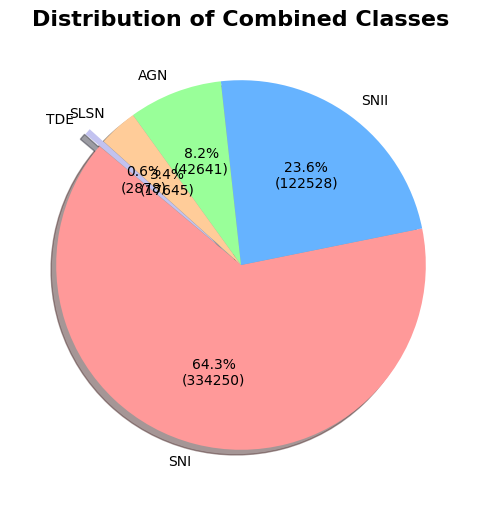

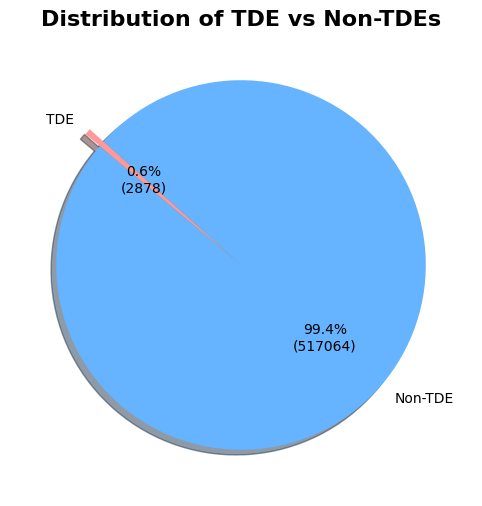

In [13]:
# Combined classes and their respective object types
combined_classes = {
    'TDE': ['TDE'],
    'SNI': ['SNIa-SALT3', 'SNIa-91bg', 'SNIax', 'SNIcBL+HostXT_V19', 'SNIb+HostXT_V19'],
    'SNII': ['SNIIn-MOSFIT', 'SNII-NMF', 'SNII+HostXT_V19', 'SNIIb+HostXT_V19'],
    'CLAGN': ['CLAGN'],
    'KN': ['KN_K17', 'KN_B19'],
    'SLSN': ['SLSN-I+host', 'SLSN-I_no_host']
  
}

# Create a combined class column in df0
df0['Combined_Class'] = df0['Object_Type']
for combined_class, original_classes in combined_classes.items():
    df0.loc[df0['Object_Type'].isin(original_classes), 'Combined_Class'] = combined_class

# Calculate counts for each combined class
combined_class_counts = df0['Combined_Class'].value_counts()

# Define custom colors
custom_colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0','#ffb3e6']

# Explode values to highlight TDE without hiding KN
explode_values = [0.1 if combined_class == 'TDE' else 0 for combined_class in combined_class_counts.index]

# Custom autopct function to show percentages and counts
def autopct_with_count(pct, allvalues):
    absolute = int(np.round(pct/100.*np.sum(allvalues)))
    return "{:.1f}%\n({:d})".format(pct, absolute)

# Plot pie chart for combined classes with custom colors and shadow
plt.figure(figsize=(10, 6))
combined_class_counts.plot.pie(
    autopct=lambda pct: autopct_with_count(pct, combined_class_counts.values),
    colors=custom_colors,
    startangle=140,
    shadow=True,
    explode=explode_values
)
plt.title('Distribution of Combined Classes', fontsize=16, fontweight='bold')
plt.ylabel('')
plt.show()

# Map combined classes to TDE vs Non-TDEs
df0['TDE_vs_NonTDE'] = df0['Combined_Class'].apply(lambda x: 'TDE' if x == 'TDE' else 'Non-TDE')

# Calculate counts for TDE vs Non-TDEs
tde_vs_nontde_counts = df0['TDE_vs_NonTDE'].value_counts()

# Plot pie chart for TDE vs Non-TDEs with custom colors and shadow
plt.figure(figsize=(8, 6))
tde_vs_nontde_counts.plot.pie(
    autopct=lambda pct: autopct_with_count(pct, tde_vs_nontde_counts.values),
    colors=['#66b3ff', '#ff9999'],
    startangle=140,
    shadow=True,
    explode=[0.1 if combined_class == 'TDE' else 0 for combined_class in tde_vs_nontde_counts.index]
)
plt.title('Distribution of TDE vs Non-TDEs', fontsize=16, fontweight='bold')
plt.ylabel('')
plt.show()


Figure saved to /home/bhardwaj/notebooksLSST/tdes-fzu/home/bhardwaj/notebooksLSST/tdes-fzu/notebooksLSST/ELAsTiCC2_processed/results-images/successrate


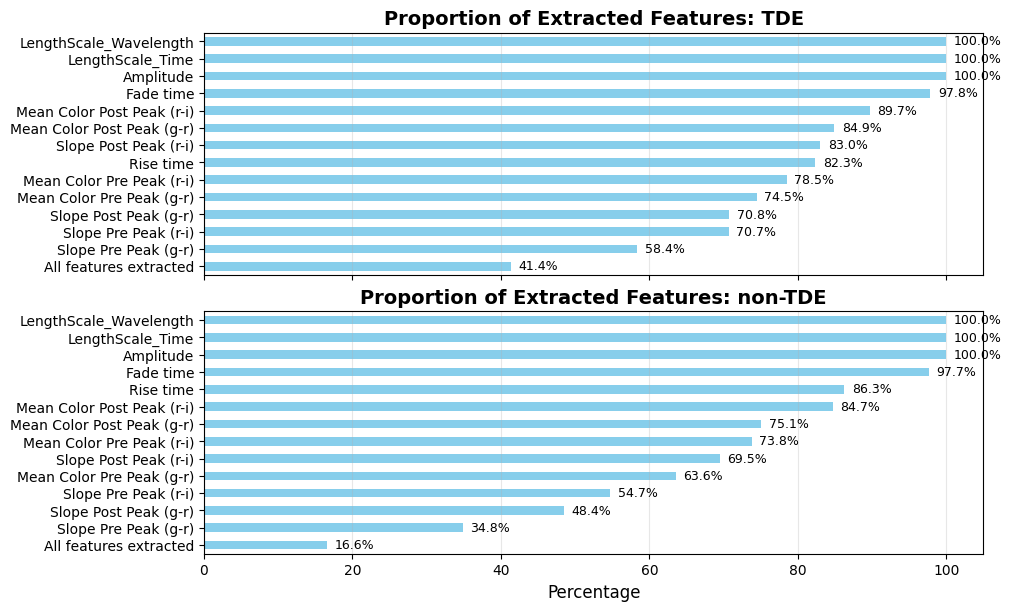

In [220]:
import matplotlib.pyplot as plt

# Define which Object_Types are considered TDE
tde_types = ['TDE']  # Replace 'TDE' with the actual values that represent TDE in your data

# Create a new column in the DataFrame to categorize as 'TDE' or 'non-TDE'
df0['Category'] = df0['Object_Type'].apply(lambda x: 'TDE' if x in tde_types else 'non-TDE')

# Dictionary mapping old column names to new column names
rename_mapping = {
    'Rise_Time': 'Rise time',
    'Fade_Time': 'Fade time',
    'Mean_Color_Pre_Peak_gr': 'Mean Color Pre Peak (g-r)',
    'Mean_Color_Pre_Peak_ri': 'Mean Color Pre Peak (r-i)',
    'Mean_Color_Post_Peak_ri': 'Mean Color Post Peak (r-i)',
    'Mean_Color_Post_Peak_gr': 'Mean Color Post Peak (g-r)',
    'Slope_Pre_Peak_gr': 'Slope Pre Peak (g-r)',
    'Slope_Pre_Peak_ri': 'Slope Pre Peak (r-i)',
    'Slope_Post_Peak_ri': 'Slope Post Peak (r-i)',
    'Slope_Post_Peak_gr': 'Slope Post Peak (g-r)'
}

# Rename the columns in the DataFrame
df0.rename(columns=rename_mapping, inplace=True)

# List of variables you want to include in the plot
selected_variables = [
    'LengthScale_Wavelength', 
    'LengthScale_Time', 
    'Amplitude',
    'Rise time', 
    'Fade time',
    'Mean Color Pre Peak (g-r)',
    'Mean Color Pre Peak (r-i)',
    'Mean Color Post Peak (r-i)',
    'Mean Color Post Peak (g-r)',
    'Slope Pre Peak (g-r)',
    'Slope Pre Peak (r-i)',
    'Slope Post Peak (r-i)',
    'Slope Post Peak (g-r)'
]

# Filter out variables that do not exist in the DataFrame (in case some were renamed incorrectly)
selected_variables = [var for var in selected_variables if var in df0.columns]

non_missing_percentage_by_category = {}

for category in ['TDE', 'non-TDE']:
    df_subset = df0[df0['Category'] == category]
    
    # Calculate the non-missing percentage for selected variables
    non_missing_percentage = df_subset[selected_variables].notnull().mean() * 100
    
    # Calculate the percentage of rows with all selected variables present
    percentage_all_present = df_subset[selected_variables].dropna().shape[0] / df_subset.shape[0] * 100
    
    # Add this percentage as a new entry to the non_missing_percentage series
    non_missing_percentage['All features extracted'] = percentage_all_present
    
    non_missing_percentage_by_category[category] = non_missing_percentage

# Plotting
# Create subplots with adjusted figure size and layout
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), sharex=True, constrained_layout=True)

for ax, (category, non_missing_percentage) in zip(axes, non_missing_percentage_by_category.items()):
    # Sort the percentages for better visualization
    non_missing_percentage_sorted = non_missing_percentage.sort_values()
    
    # Create a horizontal bar plot
    non_missing_percentage_sorted.plot(kind='barh', color='skyblue', ax=ax)
    
    # Set the title and labels
    ax.set_title(f'Proportion of Extracted Features: {category}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Percentage', fontsize=12)
    
    # Customize tick parameters for better readability
    ax.tick_params(axis='both', which='major', labelsize=10)
    
    # Add grid lines for the x-axis
    ax.grid(axis='x', alpha=0.3)
    
    # Optionally, annotate the bars with percentage values
    for i, (value, name) in enumerate(zip(non_missing_percentage_sorted, non_missing_percentage_sorted.index)):
        ax.text(value + 1, i, f'{value:.1f}%', va='center', fontsize=9)

# Save the figure once after all subplots are created
save_path = '/home/bhardwaj/notebooksLSST/tdes-fzu/home/bhardwaj/notebooksLSST/tdes-fzu/notebooksLSST/ELAsTiCC2_processed/results-images/successrate' 
plt.savefig(save_path, dpi=100)
print(f"Figure saved to {save_path}")

# Display the plot
plt.show()


## GENERAL PLOTS 

Saved LW vs LT with HDR contours to /home/bhardwaj/notebooksLSST/ELAsTiCC2_processed/LWvsLT.png


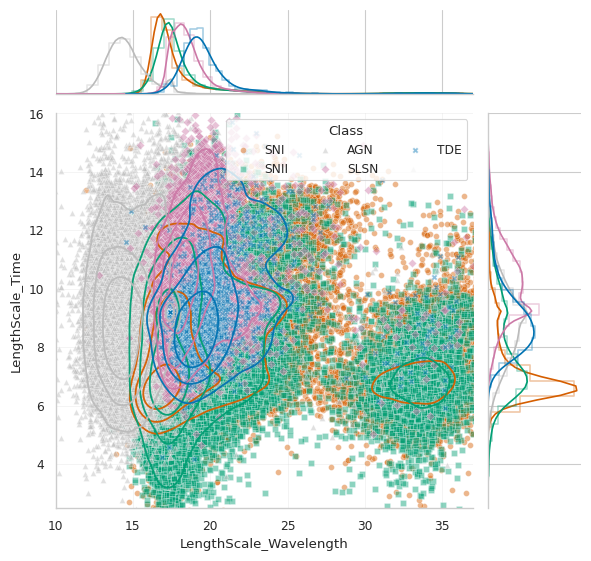

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

sns.set_theme(context="paper", style="whitegrid")

# --- helper: HDR contour levels from KDE ---
def kde_hdr_levels(x, y, probs=(0.5, 0.8, 0.95), xlim=None, ylim=None, gridsize=200):
    x = np.asarray(x); y = np.asarray(y)
    if xlim is None: xlim = (np.nanmin(x), np.nanmax(x))
    if ylim is None: ylim = (np.nanmin(y), np.nanmax(y))
    xx, yy = np.mgrid[xlim[0]:xlim[1]:complex(gridsize),
                      ylim[0]:ylim[1]:complex(gridsize)]
    kde = gaussian_kde(np.vstack([x, y]))
    zz = kde(np.vstack([xx.ravel(), yy.ravel()])).reshape(xx.shape)
    z = np.sort(zz.ravel())[::-1]
    cdf = np.cumsum(z); cdf /= cdf[-1]
    levels = [z[np.searchsorted(cdf, p)] for p in probs]
    return xx, yy, zz, np.sort(levels)

# --- Combined classes (unchanged) ---
combined_classes = {
    'SNI': ['SNIa-SALT3','SNIa-91bg','SNIax','SNIcBL+HostXT_V19','SNIb+HostXT_V19'],
    'SNII': ['SNIIn-MOSFIT','SNII-NMF','SNII+HostXT_V19','SNIIb+HostXT_V19'],
    'AGN': ['AGN'],
    'SLSN': ['SLSN-I+host','SLSN-I_no_host'],
    'TDE': ['TDE'],
}

colors = {
    'SNI':  '#D55E00', 'SNII': '#009E73', 'AGN': '#BBBBBB',
    'SLSN': '#CC79A7', 'TDE':  '#0072B2',
}
markers = {'SNI':'o','SNII':'s','AGN':'^','SLSN':'D','TDE':'X'}

# --- Collect arrays from df0 ---
rise_times  = {cls: [] for cls in combined_classes}
decay_times = {cls: [] for cls in combined_classes}
for _, row in df0.iterrows():
    for cc, orig in combined_classes.items():
        if row['Object_Type'] in orig:
            rise_times[cc].append(row['LengthScale_Wavelength'])
            decay_times[cc].append(row['LengthScale_Time'])
            break
for cls in rise_times:
    rise_times[cls]  = np.asarray(rise_times[cls], dtype=float)
    decay_times[cls] = np.asarray(decay_times[cls], dtype=float)

# --- Axis limits ---
x_min, x_max = 10, 37
y_min, y_max = 2.5, 16

joint = sns.JointGrid(height=6, ratio=4)

def _scatter_hdr_with_marginals(jg, x, y, label, color, marker):
    jg.ax_joint.scatter(x, y, s=18, marker=marker, c=color, alpha=0.45,
                        edgecolors='white', linewidths=0.4, label=label)
    if x.size >= 8:
        try:
            xx, yy, zz, levels = kde_hdr_levels(x, y, (0.5, 0.8, 0.95),
                                                xlim=(x_min, x_max), ylim=(y_min, y_max))
            jg.ax_joint.contour(xx, yy, zz, levels=levels, colors=[color], linewidths=1.3, alpha=0.95)
        except Exception:
            pass
    sns.histplot(x=x, bins=60, kde=True, stat='density', common_norm=False,
                 color=color, ax=jg.ax_marg_x, alpha=0.35, element='step', fill=False)
    sns.histplot(y=y, bins=60, kde=True, stat='density', common_norm=False,
                 color=color, ax=jg.ax_marg_y, alpha=0.35, element='step', fill=False)

for cls, color in colors.items():
    x, y = rise_times[cls], decay_times[cls]
    m = np.isfinite(x) & np.isfinite(y)
    if m.any():
        _scatter_hdr_with_marginals(joint, x[m], y[m], cls, color, markers.get(cls,'o'))

joint.set_axis_labels("LengthScale_Wavelength", "LengthScale_Time")
joint.ax_joint.set_xlim(x_min, x_max)
joint.ax_joint.set_ylim(y_min, y_max)
joint.ax_joint.grid(True, alpha=0.25, linewidth=0.6)
joint.ax_joint.legend(title="Class", ncol=3, frameon=True, loc='best')

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
save_path = '/home/bhardwaj/notebooksLSST/ELAsTiCC2_processed/LWvsLT.png'
joint.fig.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Saved LW vs LT with HDR contours to {save_path}")
plt.show()


### Color-color diagram

Pre-peak Color-Color Diagram saved to /home/bhardwaj/notebooksLSST/ELAsTiCC2_processed/results-images/colordiag_pre_peak.png
Post-peak Color-Color Diagram saved to /home/bhardwaj/notebooksLSST/ELAsTiCC2_processed/results-images/colordiag_post_peak.png


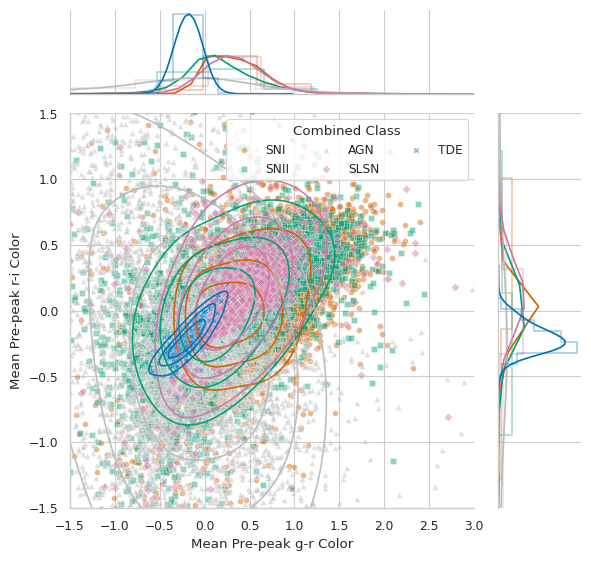

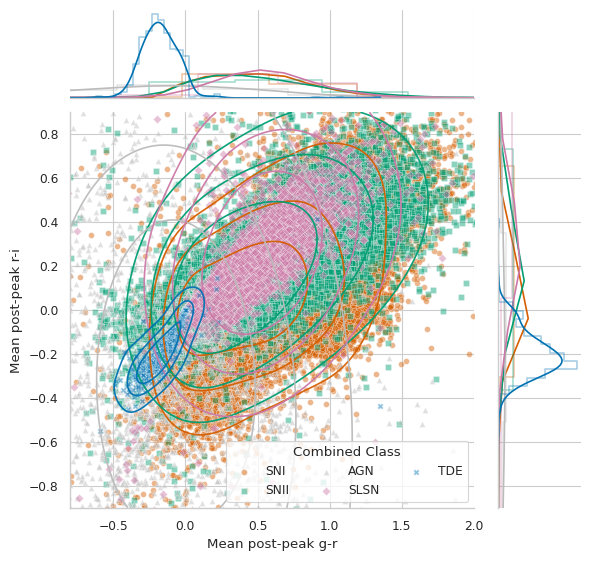

In [41]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

sns.set_theme(context="paper", style="whitegrid")

def kde_hdr_levels(x, y, probs=(0.5, 0.8, 0.95), xlim=None, ylim=None, gridsize=200):
    x = np.asarray(x); y = np.asarray(y)
    if xlim is None: xlim = (np.nanmin(x), np.nanmax(x))
    if ylim is None: ylim = (np.nanmin(y), np.nanmax(y))
    xx, yy = np.mgrid[xlim[0]:xlim[1]:complex(gridsize),
                      ylim[0]:ylim[1]:complex(gridsize)]
    kde = gaussian_kde(np.vstack([x, y]))
    zz = kde(np.vstack([xx.ravel(), yy.ravel()])).reshape(xx.shape)
    z = np.sort(zz.ravel())[::-1]
    cdf = np.cumsum(z); cdf /= cdf[-1]
    levels = [z[np.searchsorted(cdf, p)] for p in probs]
    return xx, yy, zz, np.sort(levels)

combined_classes = {
    'SNI':  ['SNIa-SALT3','SNIa-91bg','SNIax','SNIcBL+HostXT_V19','SNIb+HostXT_V19'],
    'SNII': ['SNIIn-MOSFIT','SNII-NMF','SNII+HostXT_V19','SNIIb+HostXT_V19'],
    'AGN':  ['CLAGN'],
    'SLSN': ['SLSN-I+host','SLSN-I_no_host'],
    'TDE':  ['TDE'],
}

colors = {
    'SNI':  '#D55E00', 'SNII': '#009E73', 'AGN': '#BBBBBB',
    'SLSN': '#CC79A7', 'TDE':  '#0072B2',
}
markers = {'SNI':'o','SNII':'s','AGN':'^','SLSN':'D','TDE':'X'}

df0['Combined_Class'] = df0['Object_Type']
for cc, orig in combined_classes.items():
    df0.loc[df0['Object_Type'].isin(orig), 'Combined_Class'] = cc

def _scatter_hdr_joint(joint, x, y, label, color, marker, xlim, ylim):
    joint.ax_joint.scatter(x, y, s=18, marker=marker, c=color, alpha=0.45,
                           edgecolors='white', linewidths=0.4, label=label)
    if x.size >= 8 and y.size >= 8:
        try:
            xx, yy, zz, levels = kde_hdr_levels(x, y, (0.5,0.8,0.95), xlim=xlim, ylim=ylim)
            joint.ax_joint.contour(xx, yy, zz, levels=levels, colors=[color], linewidths=1.2, alpha=0.95)
        except Exception:
            pass
    sns.histplot(x=x, bins=60, kde=True, stat='density', common_norm=False,
                 color=color, ax=joint.ax_marg_x, alpha=0.35, element='step', fill=False)
    sns.histplot(y=y, bins=60, kde=True, stat='density', common_norm=False,
                 color=color, ax=joint.ax_marg_y, alpha=0.35, element='step', fill=False)

RANDOM_SEED = 42

# ----- Pre-peak -----
pre_xlim, pre_ylim = (-1.5, 3.0), (-1.5, 1.5)
pre_joint = sns.JointGrid(height=6, ratio=4)
for cls, color in colors.items():
    dfc = df0.loc[df0['Combined_Class'] == cls]
    if dfc.empty: continue
    dfc = dfc.sample(frac=0.30, random_state=RANDOM_SEED)
    x = dfc['Mean Color Pre Peak (g-r)'].to_numpy(float)
    y = dfc['Mean Color Pre Peak (r-i)'].to_numpy(float)
    m = np.isfinite(x) & np.isfinite(y)
    if not m.any(): continue
    _scatter_hdr_joint(pre_joint, x[m], y[m], cls, color, markers.get(cls,'o'),
                       xlim=pre_xlim, ylim=pre_ylim)

pre_joint.set_axis_labels("Mean Pre-peak g-r Color", "Mean Pre-peak r-i Color")
pre_joint.ax_joint.set_xlim(*pre_xlim)
pre_joint.ax_joint.set_ylim(*pre_ylim)
pre_joint.ax_joint.legend(title='Combined Class', ncol=3, frameon=True, loc='best')
plt.tight_layout(rect=[0, 0.03, 1, 0.98])

save_path_pre = '/home/bhardwaj/notebooksLSST/ELAsTiCC2_processed/results-images/colordiag_pre_peak.png'
pre_joint.fig.savefig(save_path_pre, dpi=150, bbox_inches='tight')
print(f"Pre-peak Color-Color Diagram saved to {save_path_pre}")

# ----- Post-peak -----
post_xlim, post_ylim = (-0.8, 2.0), (-0.9, 0.9)
post_joint = sns.JointGrid(height=6, ratio=4)
for cls, color in colors.items():
    dfc = df0.loc[df0['Combined_Class'] == cls]
    if dfc.empty: continue
    dfc = dfc.sample(frac=0.20, random_state=RANDOM_SEED)
    x = dfc['Mean Color Post Peak (g-r)'].to_numpy(float)
    y = dfc['Mean Color Post Peak (r-i)'].to_numpy(float)
    m = np.isfinite(x) & np.isfinite(y)
    if not m.any(): continue
    _scatter_hdr_joint(post_joint, x[m], y[m], cls, color, markers.get(cls,'o'),
                       xlim=post_xlim, ylim=post_ylim)

post_joint.set_axis_labels("Mean post-peak g-r", "Mean post-peak r-i")
post_joint.ax_joint.set_xlim(*post_xlim)
post_joint.ax_joint.set_ylim(*post_ylim)
post_joint.ax_joint.legend(title='Combined Class', ncol=3, frameon=True, loc='lower right')
plt.tight_layout(rect=[0, 0.03, 1, 0.98])

save_path_post = '/home/bhardwaj/notebooksLSST/ELAsTiCC2_processed/results-images/colordiag_post_peak.png'
post_joint.fig.savefig(save_path_post, dpi=150, bbox_inches='tight')
print(f"Post-peak Color-Color Diagram saved to {save_path_post}")

plt.show()


### rate of color change vs mean color

/tmp/ipykernel_1397029/732012531.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=0.5, random_state=RANDOM_SEED) if len(x) > 1 else x)


Saved g-r color–slope plot with HDR contours to /home/bhardwaj/notebooksLSST/ELAsTiCC2_processed/colorvslope_gr.png


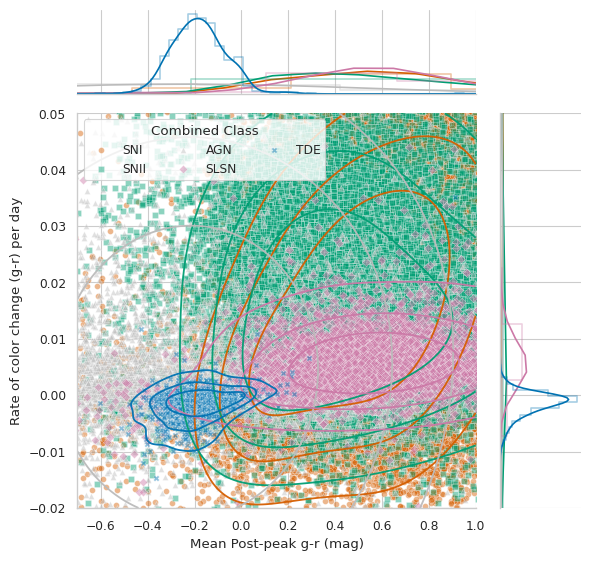

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

sns.set_theme(context="paper", style="whitegrid")

def kde_hdr_levels(x, y, probs=(0.5, 0.8, 0.95), xlim=None, ylim=None, gridsize=200):
    x = np.asarray(x); y = np.asarray(y)
    if xlim is None: xlim = (np.nanmin(x), np.nanmax(x))
    if ylim is None: ylim = (np.nanmin(y), np.nanmax(y))
    xx, yy = np.mgrid[xlim[0]:xlim[1]:complex(gridsize),
                      ylim[0]:ylim[1]:complex(gridsize)]
    kde = gaussian_kde(np.vstack([x, y]))
    zz = kde(np.vstack([xx.ravel(), yy.ravel()])).reshape(xx.shape)
    z = np.sort(zz.ravel())[::-1]
    cdf = np.cumsum(z); cdf /= cdf[-1]
    levels = [z[np.searchsorted(cdf, p)] for p in probs]
    return xx, yy, zz, np.sort(levels)

# Ensure Combined_Class exists
if 'Combined_Class' not in df0.columns:
    df0 = df0.copy()
    df0['Combined_Class'] = df0['Object_Type']

colors = {
    'SNI':  '#D55E00', 'SNII': '#009E73', 'AGN': '#BBBBBB',
    'SLSN': '#CC79A7', 'TDE':  '#0072B2',
}
markers = {'SNI':'o','SNII':'s','AGN':'^','SLSN':'D','TDE':'X'}

# Sample 50% per class
RANDOM_SEED = 42
df_sampled = (
    df0.groupby('Combined_Class', group_keys=False)
       .apply(lambda x: x.sample(frac=0.5, random_state=RANDOM_SEED) if len(x) > 1 else x)
       .reset_index(drop=True)
)

joint = sns.JointGrid(height=6, ratio=4)

def _scatter_hdr_marginals(jg, x, y, label, color, marker, xlim, ylim):
    jg.ax_joint.scatter(x, y, s=18, marker=marker, c=color, alpha=0.45,
                        edgecolors='white', linewidths=0.4, label=label)
    if x.size >= 8 and y.size >= 8:
        try:
            xx, yy, zz, levels = kde_hdr_levels(x, y, (0.5,0.8,0.95), xlim=xlim, ylim=ylim)
            jg.ax_joint.contour(xx, yy, zz, levels=levels, colors=[color], linewidths=1.3, alpha=0.95)
        except Exception:
            pass
    sns.histplot(x=x, bins=60, kde=True, stat='density', common_norm=False,
                 color=color, ax=jg.ax_marg_x, alpha=0.35, element='step', fill=False)
    sns.histplot(y=y, bins=60, kde=True, stat='density', common_norm=False,
                 color=color, ax=jg.ax_marg_y, alpha=0.35, element='step', fill=False)

# Axis limits for this plot
xlim = (-0.7, 1.0)
ylim = (-0.02, 0.05)

# Per class
for cls, color in colors.items():
    sub = df_sampled.loc[df_sampled['Combined_Class'] == cls]
    if sub.empty: continue
    x = sub['Mean Color Post Peak (g-r)'].to_numpy(float)
    y = sub['Slope Post Peak (g-r)'].to_numpy(float)
    m = np.isfinite(x) & np.isfinite(y)
    if not m.any(): continue
    _scatter_hdr_marginals(joint, x[m], y[m], cls, color, markers.get(cls,'o'), xlim, ylim)

joint.set_axis_labels("Mean Post-peak g-r (mag)", "Rate of color change (g-r) per day")
joint.ax_joint.set_xlim(*xlim)
joint.ax_joint.set_ylim(*ylim)
joint.ax_joint.legend(title='Combined Class', ncol=3, frameon=True, loc='upper left')
plt.tight_layout(rect=[0, 0.03, 1, 0.98])

save_path = '/home/bhardwaj/notebooksLSST/ELAsTiCC2_processed/colorvslope_gr.png'
joint.fig.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Saved g-r color–slope plot with HDR contours to {save_path}")

plt.show()


### variable distributions 

/tmp/ipykernel_3012395/480596254.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df0.rename(columns=rename_map, inplace=True)


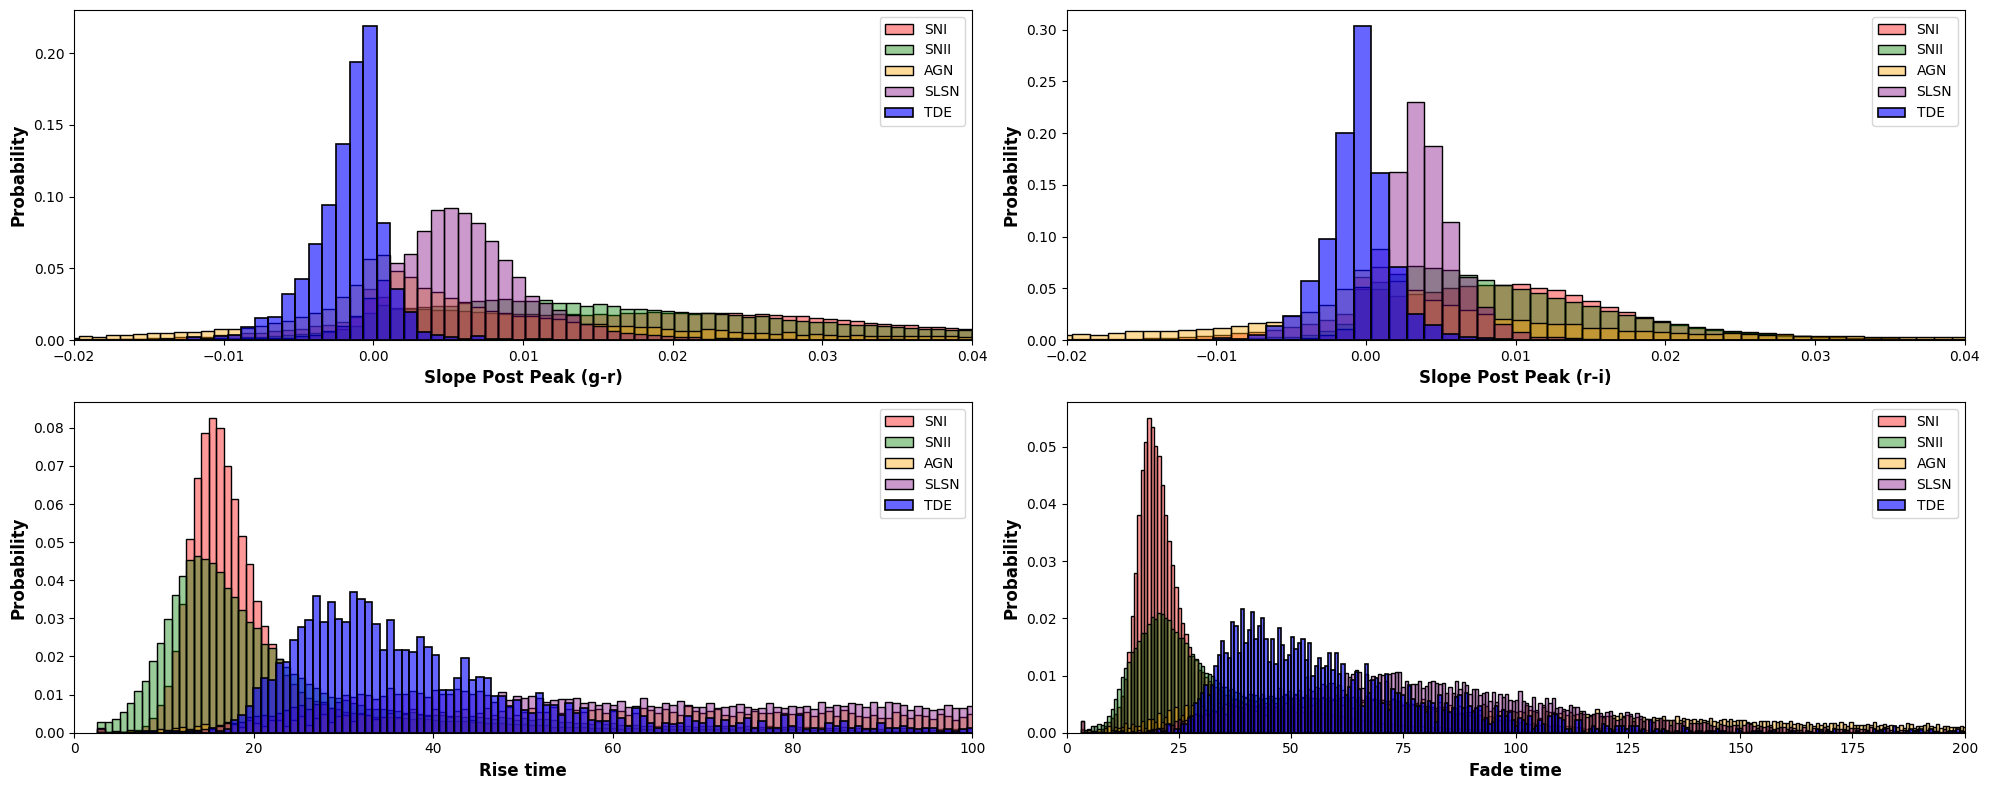

In [34]:
# Assuming df0 is your DataFrame with all object types
colors = {
    'SNI': 'red',
    'SNII': 'green',
    'AGN': 'orange',
 #   'KN': 'purple',
    'SLSN': 'purple',
    'TDE': 'blue'
}

combined_classes = {
    'SNI': ['SNIa-SALT3', 'SNIa-91bg', 'SNIax', 'SNIcBL+HostXT_V19', 'SNIb+HostXT_V19'],
    'SNII': ['SNIIn-MOSFIT', 'SNII-NMF', 'SNII+HostXT_V19', 'SNIIb+HostXT_V19'],
    'AGN': ['AGN'],
#    'KN': ['KN_K17', 'KN_B19'],
    'SLSN': ['SLSN-I+host', 'SLSN-I_no_host'],
    'TDE': ['TDE']
}

rename_map = {
    'Mean_Color_Pre_Peak_gr': 'Mean Color Pre Peak (g-r)',
    'Mean_Color_Post_Peak_gr': 'Mean Color Post Peak (g-r)',
    'Mean_Color_Pre_Peak_ri': 'Mean Color Pre Peak (r-i)',
    'Mean_Color_Post_Peak_ri': 'Mean Color Post Peak (r-i)',
    'Slope_Pre_Peak_gr': 'Slope Pre Peak (g-r)',
    'Slope_Post_Peak_gr': 'Slope Post Peak (g-r)',
    'Slope_Pre_Peak_ri': 'Slope Pre Peak (r-i)',
    'Slope_Post_Peak_ri': 'Slope Post Peak (r-i)',
    'Rise_Time': 'Rise time',
    'Fade_Time': 'Fade time'
    
}

df0.rename(columns=rename_map, inplace=True)

# Filtered columns based on your criteria
filtered_columns = [
 #   'Amplitude',
 #   'LengthScale_Time',
 #   'LengthScale_Wavelength',
 #   'Mean Color Pre Peak (g-r)',
 #   'Mean Color Post Peak (g-r)',
 #   'Mean Color Pre Peak (r-i)',
 #   'Mean Color Post Peak (r-i)',
#     'Slope Pre Peak (g-r)',
     'Slope Post Peak (g-r)',
   #  'Slope Pre Peak (r-i)',
     'Slope Post Peak (r-i)',
     'Rise time',
     'Fade time'
    
]

# Custom axis limits
custom_limits = {
    'Amplitude': (5, 15),
    'LengthScale_Time': (4, 14),
    'LengthScale_Wavelength': (12, 24),
    'Mean Color Pre Peak (g-r)': (-0.8, 0.8),
    'Mean Color Pre Peak (r-i)': (-0.8, 0.8),
    'Mean Color Post Peak (g-r)': (-0.8, 0.8),
    'Mean Color Post Peak (r-i)': (-0.8, 0.8),
    'Slope Pre Peak (g-r)': (-0.04, 0.04),
    'Slope Pre Peak (r-i)': (-0.04, 0.04),
    'Slope Post Peak (g-r)': (-0.02, 0.04),
    'Slope Post Peak (r-i)': (-0.02, 0.04),
    'Rise time': (0, 100),
    'Fade time': (0, 200)
}


# Calculate the number of rows needed for the subplots
num_rows = int(np.ceil(len(filtered_columns) / 2))

# Set up the matplotlib figure with the right number of subplots
fig, axes = plt.subplots(num_rows, 2, figsize=(20, 4 * num_rows))
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Loop through the filtered columns and create the plots for each object type
for i, col in enumerate(filtered_columns):
    ax = axes[i]

    # Determine quantile range for binning (e.g., 5th to 95th percentile)
    lower_quantile = df0[col].quantile(0.0005)
    upper_quantile = df0[col].quantile(0.9995)
    
    # Adjust the binning strategy to focus on the specified quantile range
    bins = np.linspace(lower_quantile, upper_quantile, 1000)  # Reduced number of bins to smooth the distribution

    # Plot histograms for each object type
    for class_type, obj_types in combined_classes.items():
        data = df0[df0['Object_Type'].isin(obj_types)][col].clip(lower_quantile, upper_quantile)
        alpha = 0.6 if class_type == 'TDE' else 0.4  # Emphasize TDE by setting alpha to 0.6
        linewidth = 1.2 if class_type == 'TDE' else 1  # Emphasize TDE by setting linewidth to 1.5
        
        # Adjust KDE using bw_adjust to better fit the data
        sns.histplot(
            data, bins=bins, color=colors[class_type], label=class_type, stat="probability", linewidth=linewidth,
            ax=ax, alpha=alpha, kde=False, kde_kws={'bw_adjust': 0.1}  # Lower bandwidth for tighter KDE fit
        )

    # Set custom axis limits if specified
    if col in custom_limits:
        ax.set_xlim(custom_limits[col])

    ax.set_xlabel(col, fontsize=12, fontweight='bold')
    ax.set_ylabel('Probability', fontsize=12, fontweight='bold')
    ax.legend(loc='upper right')  # Add legend to each subplot

# Check if there are any unused axes and remove them
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('/home/bhardwaj/notebooksLSST/ELAsTiCC2_processed/variable_dist1.png', dpi=300)
plt.show()


In [ ]:
colors = {
    'TDE': 'blue',
    'Non-TDE': 'white'
}

combined_classes = {
    'TDE': ['TDE'],
    'Non-TDE': [
        'SNIa-SALT3', 'SNIa-91bg', 'SNIax', 'SNIcBL+HostXT_V19', 'SNIb+HostXT_V19', 
        'SNIIn-MOSFIT', 'SNII-NMF', 'SNII+HostXT_V19', 'SNIIb+HostXT_V19', 
        'CLAGN', 'KN_K17', 'KN_B19', 'SLSN-I+host', 'SLSN-I_no_host'
    ]
}

# Filtered columns based on your criteria
filtered_columns = [
    'Amplitude',
    'LengthScale_Time',
    'LengthScale_Wavelength',
    'Mean_Color_Pre_Peak',
    'Mean_Color_Post_Peak',
    'Slope_Pre_Peak',
    'Slope_Post_Peak',
    'Rise_Time',
    'Decay_Time'
]

# Calculate the number of rows needed for the subplots
num_rows = int(np.ceil(len(filtered_columns) / 2))

# Set up the matplotlib figure with the right number of subplots
fig, axes = plt.subplots(num_rows, 2, figsize=(20, 4 * num_rows))
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Loop through the filtered columns and create the plots for each object type 'Mean_Color_Pre_Peak_GR',

for i, col in enumerate(filtered_columns):
    ax = axes[i]

    # Determine quantile range for binning (e.g., 5th to 95th percentile)
    lower_quantile = df0[col].quantile(0.0005)
    upper_quantile = df0[col].quantile(0.9995)
    
    # Adjust the binning strategy to focus on the specified quantile range
    bins = np.linspace(lower_quantile, upper_quantile, 100)  

    # Plot histograms for TDE and Others
    for class_type, obj_types in combined_classes.items():
        data = df0[df0['Object_Type'].isin(obj_types)][col].clip(lower_quantile, upper_quantile)
        alpha = 1.0 if class_type == 'TDE' else 0.5  # Emphasize TDE by setting alpha to 1.0
        linewidth = 2 if class_type == 'TDE' else 1  # Emphasize TDE by setting linewidth to 2
        sns.histplot(data, bins=bins, color=colors[class_type], label=class_type if i == 0 else "", stat="probability", linewidth=linewidth, ax=ax, alpha=alpha, kde=True, )

    ax.set_xlabel(col, fontsize=12, fontweight='bold')
    ax.set_ylabel('Probability', fontsize=12, fontweight='bold')
    if i == 0:  # Add legend only to the first subplot for clarity
        ax.legend()

# Check if there are any unused axes and remove them
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## Correlation, ML classifiers

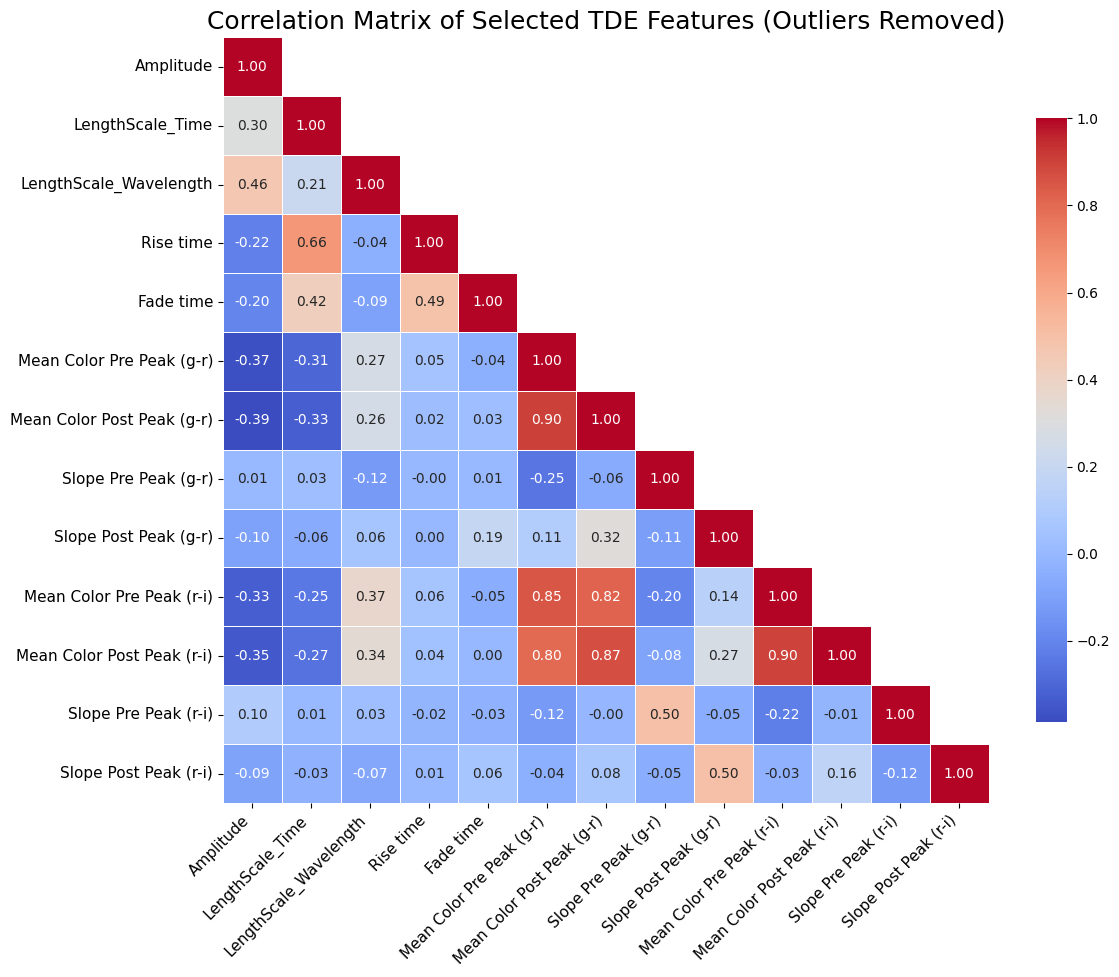

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_correlation_heatmap(data, columns):
    plt.figure(figsize=(12, 10)) 

    # Compute the correlation matrix
    corr_matrix = data[columns].corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

    # Draw the heatmap
    sns.heatmap(
        corr_matrix,
        mask=mask,
        cmap='coolwarm',
        annot=True,
        fmt=".2f",
        square=True,
        cbar_kws={"shrink": .75},
        linewidths=.5
    )

    # Title and layout adjustments
    plt.title('Correlation Matrix of Selected TDE Features (Outliers Removed)', fontsize=18)
    plt.xticks(rotation=45, ha='right', fontsize=11)
    plt.yticks(fontsize=11)
    plt.tight_layout()
    plt.savefig('/home/bhardwaj/notebooksLSST/ELAsTiCC2_processed/corrTDE_no_outliers.png', dpi=150)
    plt.show()

# Plot the correlation heatmap
plot_correlation_heatmap(df_tde_no_outliers, filtered_columns)


### ML Classifiers

In [3]:
# Define the file path
file_path = '/home/bhardwaj/notebooksLSST/ELAsTiCC2_processed/hdf5_files/ELAsTiCC2_Test.csv'
# Read the CSV file into a DataFrame
df0 = pd.read_csv(file_path)

# Display the first few rows of the DataFrame to ensure it was loaded correctly
#print(df0.head())
df0


SNID      Object_Type  Amplitude  LengthScale_Time  \
0        47689198              AGN   6.402101          8.925621   
1       116418933              AGN   7.052263          8.387232   
2        37614935              AGN   8.464618          8.531716   
3       154387816              AGN   6.758663          8.909314   
4       144438995              AGN   8.256223          9.729403   
...           ...              ...        ...               ...   
519937   69210531  SNIb+HostXT_V19   9.881999          7.210203   
519938  151362690  SNIb+HostXT_V19   7.425029          8.197762   
519939  134561142  SNIb+HostXT_V19  10.608138         13.700365   
519940   42613033  SNIb+HostXT_V19   9.962642          6.952170   
519941   74054182  SNIb+HostXT_V19   5.980929          7.445961   

        LengthScale_Wavelength   Rise_Time   Fade_Time  TruePeakMJD  \
0                    15.155287  455.928051  240.154615    60796.500   
1                    13.986228  113.191734   75.461156    60795.867   
2                    14.507958   36.320022   43.584026    60795.996   
3                    13.366818   99.343151  172.485911    60796.650   
4                    15.744421         NaN  117.035820    60794.670   
...                        ...         ...         ...          ...   
519937               17.392012   22.606671   23.313129    61587.900   
519938               16.955800   25.725187   24.065498    61395.277   
519939               21.643595   97.456751         NaN    60887.668   
519940               17.269916   15.513540   23.270310    61345.680   
519941               17.999917   20.018417   22.748201    60940.800   

        peak_time_MJD  Mean_Color_Pre_Peak_gr  ...  Slope_Err_Post_Peak_gr  \
0        61459.233132                0.111467  ...                0.004793   
1        61797.875319               -0.937540  ...                0.000434   
2        61844.761915                     NaN  ...                     NaN   
3        60973.731051               -2.216868  ...                     NaN   
4        60794.444779                     NaN  ...                     NaN   
...               ...                     ...  ...                     ...   
519937   61198.637507                0.089954  ...                     NaN   
519938   61569.986865                     NaN  ...                     NaN   
519939   61966.406800                0.228431  ...                     NaN   
519940   60992.773094                     NaN  ...                0.000440   
519941   61584.879012                     NaN  ...                0.000020   

        Mean_Color_Pre_Peak_ri  Pre_Peak_Color_err_ri  \
0                    -0.274985               0.025944   
1                     0.185397               0.060709   
2                          NaN                    NaN   
3                          NaN                    NaN   
4                          NaN                    NaN   
...                        ...                    ...   
519937               -0.033026               0.028758   
519938                0.424339               0.449168   
519939                0.208506               0.035409   
519940                     NaN                    NaN   
519941                     NaN                    NaN   

        Mean_Color_Post_Peak_ri  Post_Peak_Color_err_ri  Slope_Pre_Peak_ri  \
0                      0.502878                0.099836           0.005569   
1                     -0.507557                0.546949           0.008750   
2                           NaN                     NaN                NaN   
3                           NaN                     NaN                NaN   
4                           NaN                     NaN                NaN   
...                         ...                     ...                ...   
519937                 0.149751                0.009862                NaN   
519938                 0.654348                0.051026                NaN   
519939                      NaN

### Binary Classification: TDE vs Others

#### RF

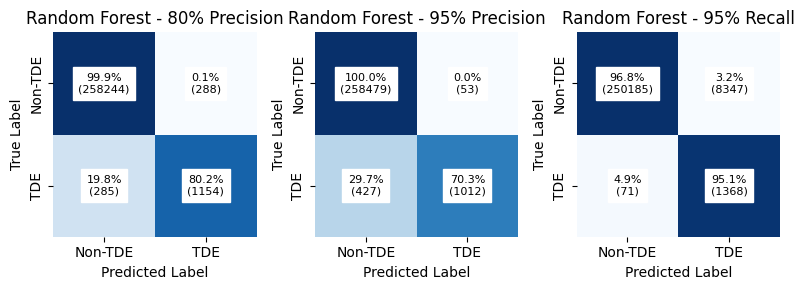

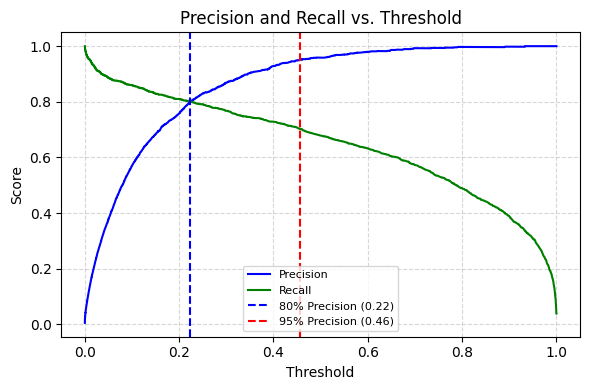

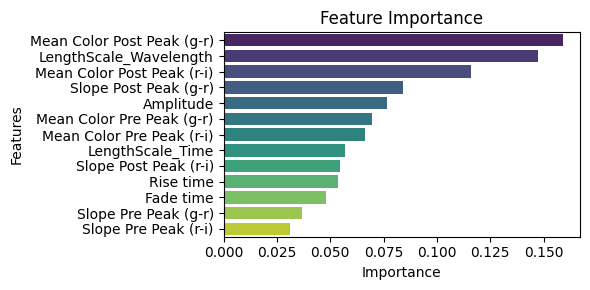

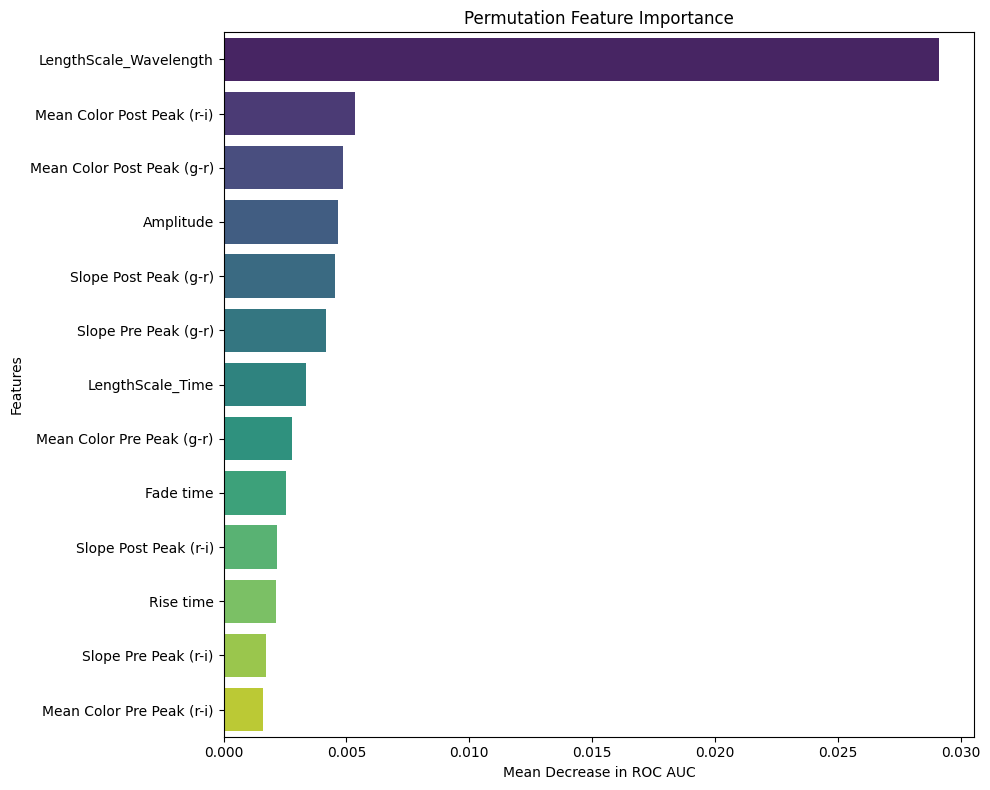

In [334]:
# Prepare subplots with wider horizontal layout
fig_rf, axs_rf = plt.subplots(1, 3, figsize=(8, 3))  # 1 row, 3 columns with a total size of 18x6 inches

# Plot confusion matrices
for i in range(3):
    cm_rf = confusion_matrix(y_test, all_predictions_rf[i], labels=[0, 1])
    title_rf = classifier_titles_rf[i]
    plot_confusion_matrix(cm_rf, axs_rf[i], title_rf, normalize=True)

# Adjust layout, save, and display the confusion matrices plot
plt.tight_layout()
confusion_matrix_path_rf = os.path.join(save_directory_rf, 'RandomForest_confusion_matrices.png')
plt.savefig(confusion_matrix_path_rf, dpi=300)
plt.show()
plt.close()  # Close the figure to free memory

# ---------------------------------------
# Plotting Precision and Recall Curves
# ---------------------------------------

# Define thresholds to mark
thresholds_to_mark_rf = {
    '80% Precision': threshold_80p_precision_rf,
    '95% Precision': threshold_95p_precision_rf
}

# Define save path for Precision-Recall curve
save_path_pr_rf = os.path.join(save_directory_rf, 'RandomForest_precision_recall.png')

# Define desired figure size for Precision-Recall curve
pr_figsize_rf = (6, 4)  # Adjust as needed

# Plot and save Precision-Recall curve
plot_precision_recall_curve(y_test, y_probs_rf, thresholds_to_mark_rf, save_path_pr_rf, figsize=pr_figsize_rf)

# ---------------------------------------
# Plotting Feature Importance
# ---------------------------------------

# Define save path for Feature Importance plot
save_path_fi_rf = os.path.join(save_directory_rf, 'RandomForest_feature_importance.png')

# Define desired figure size for Feature Importance plot
fi_figsize_rf = (6, 3)  # Adjust as needed

# Plot and save Feature Importance
plot_feature_importance(best_rf, feature_columns, save_path_fi_rf, figsize=fi_figsize_rf)

# Optionally, plot Permutation Feature Importance
save_path_perm_fi_rf = os.path.join(save_directory_rf, 'RandomForest_permutation_importance.png')
plot_permutation_importance_rf(best_rf, X_test, y_test, feature_columns, save_path_perm_fi_rf, figsize=(10, 8))

#### XGB

Class distribution:
Training set:
 Simple_Object_Type
0    258532
1      1439
Name: count, dtype: int64

Test set:
 Simple_Object_Type
0    258532
1      1439
Name: count, dtype: int64

Estimated scale_pos_weight ≈ 179.7 (neg/pos) from the training split.
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/home/bhardwaj/.local/lib/python3.11/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/home/bhardwaj/.local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [11:13:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/bhardwaj/.local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [11:13:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/bhardwaj/.local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [11:13:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/


Best parameters found: {'colsample_bytree': np.float64(0.8572979613500311), 'gamma': np.float64(3.3009868835886564), 'learning_rate': np.float64(0.09398016908378284), 'max_depth': 7, 'min_child_weight': 7, 'n_estimators': 291, 'scale_pos_weight': np.float64(208.8826231512598), 'subsample': np.float64(0.8058603731171761)}
Best recall at 80% precision: 0.7929


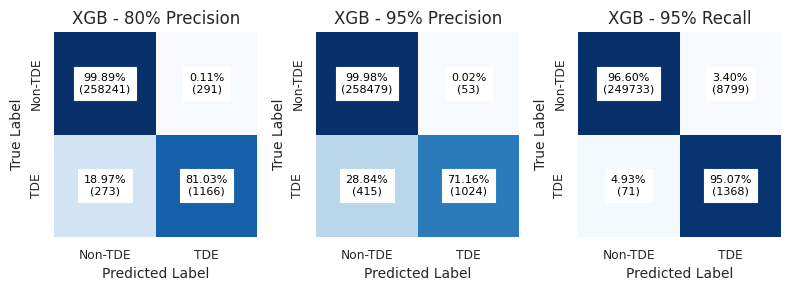

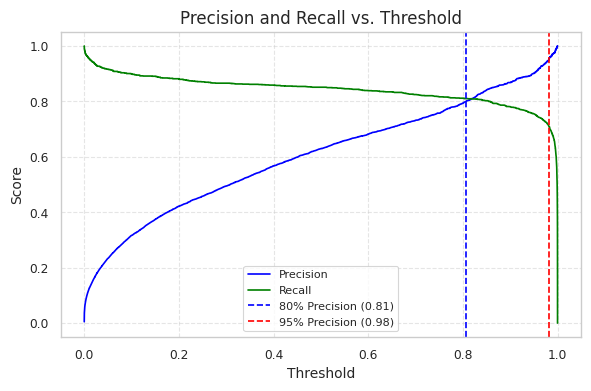

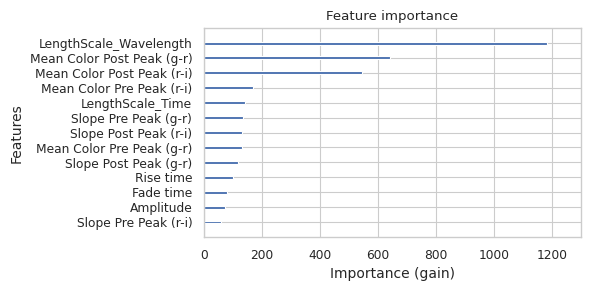


XGB - 80% Precision Classification Report:
              precision    recall  f1-score   support

     Non-TDE       1.00      1.00      1.00    258532
         TDE       0.80      0.81      0.81      1439

    accuracy                           1.00    259971
   macro avg       0.90      0.90      0.90    259971
weighted avg       1.00      1.00      1.00    259971

ROC AUC: 0.9931

XGB - 95% Precision Classification Report:
              precision    recall  f1-score   support

     Non-TDE       1.00      1.00      1.00    258532
         TDE       0.95      0.71      0.81      1439

    accuracy                           1.00    259971
   macro avg       0.97      0.86      0.91    259971
weighted avg       1.00      1.00      1.00    259971

ROC AUC: 0.9931

XGB - 95% Recall Classification Report:
              precision    recall  f1-score   support

     Non-TDE       1.00      0.97      0.98    258532
         TDE       0.13      0.95      0.24      1439

    accuracy         

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import (
    confusion_matrix, precision_recall_curve, classification_report, roc_auc_score,
    make_scorer
)
import xgboost as xgb
import os
from scipy.stats import uniform, randint, loguniform  # <-- added loguniform

# ---------------------------------------
# Helper Functions
# ---------------------------------------

def find_threshold(y_true, y_probs, target='precision', target_value=0.95):
    """
    Find the threshold for desired precision or recall.

    Parameters:
    - y_true: Ground truth binary labels.
    - y_probs: Predicted probabilities for the positive class.
    - target: 'precision' or 'recall'.
    - target_value: Desired value for the target metric.

    Returns:
    - Threshold value.
    """
    precision, recall, thresholds = precision_recall_curve(y_true, y_probs)

    if target == 'precision':
        idx = np.where(precision >= target_value)[0]
        if len(idx) == 0:
            print(f"No threshold found to achieve {target_value*100:.0f}% precision. Returning threshold=1.0")
            return 1.0
        return thresholds[idx[0]]

    elif target == 'recall':
        idx = np.where(recall >= target_value)[0]
        if len(idx) == 0:
            print(f"No threshold found to achieve {target_value*100:.0f}% recall. Returning threshold=0.0")
            return 0.0
        return thresholds[idx[-1]]

    else:
        raise ValueError("Target must be 'precision' or 'recall'.")

def plot_confusion_matrix(cm, ax, title, normalize=True):
    """
    Plot a confusion matrix with percentages and counts.
    """
    if normalize:
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        cm_normalized = cm

    sns.heatmap(
        cm_normalized, annot=False, fmt='.2f', cmap='Blues', ax=ax,
        xticklabels=['Non-TDE', 'TDE'], yticklabels=['Non-TDE', 'TDE'], cbar=False
    )

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if normalize:
                percentage = cm_normalized[i, j] * 100
                count = cm[i, j]
                text = f'{percentage:.2f}%\n({count})'
            else:
                text = f'{cm[i, j]}'
            ax.text(
                j + 0.5, i + 0.5, text, ha='center', va='center',
                color='black', fontsize=8, bbox=dict(facecolor='white', edgecolor='white')
            )

    ax.set_xlabel('Predicted Label', fontsize=10)
    ax.set_ylabel('True Label', fontsize=10)
    ax.set_title(title, fontsize=12)

def plot_precision_recall_curve(y_true, y_probs, thresholds_to_mark, save_path, figsize=(6, 4)):
    """
    Plot Precision and Recall vs threshold and mark chosen thresholds.
    """
    precision, recall, thresholds = precision_recall_curve(y_true, y_probs)

    plt.figure(figsize=figsize)
    plt.plot(thresholds, precision[:-1], label='Precision', color='blue')
    plt.plot(thresholds, recall[:-1], label='Recall', color='green')

    for label, thresh in thresholds_to_mark.items():
        color = 'red' if '95% Precision' in label else 'blue'
        plt.axvline(x=thresh, linestyle='--', color=color, label=f'{label} ({thresh:.2f})')

    plt.xlabel('Threshold', fontsize=10)
    plt.ylabel('Score', fontsize=10)
    plt.title('Precision and Recall vs. Threshold', fontsize=12)
    plt.legend(fontsize=8)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()
    plt.close()

def plot_feature_importance(model, feature_names, save_path, figsize=(8, 6)):
    """
    Plot and save the feature importance from the XGBoost model.
    """
    plt.figure(figsize=figsize)
    ax = plt.gca()
    xgb.plot_importance(
        model,
        max_num_features=20,
        importance_type='gain',
        show_values=False,
        ax=ax
    )
    plt.xlabel('Importance (gain)', fontsize=10)
    plt.ylabel('Features', fontsize=10)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()
    plt.close()

# ---------------------------------------
# Data Preparation
# ---------------------------------------

# Ensure df0 is loaded
if 'df0' not in locals():
    raise ValueError("DataFrame 'df0' is not loaded. Please load your data into 'df0' before running the script.")

# Create a simplified object type column
df0['Simple_Object_Type'] = df0['Object_Type'].apply(lambda x: 'TDE' if x == 'TDE' else 'Other')

# Select numeric columns for the model and exclude specified columns
excluded_columns = [
    'SNID', 
    'PeakMag',
    'PeakMagErr',
    'REDSHIFT_FINAL',
    'REDSHIFT_FINAL_ERR',
]

# Exclude columns containing 'err', 'flux', or 'mjd'
excluded_columns += [col for col in df0.columns if 'err' in col.lower() or 'flux' in col.lower() or 'mjd' in col.lower()]

# Select feature columns
feature_columns = [col for col in df0.select_dtypes(include=[np.number]).columns if col not in excluded_columns]

# Renaming columns for clarity
rename_map = {
    'Mean_Color_Pre_Peak_gr': 'Mean Color Pre Peak (g-r)',
    'Mean_Color_Post_Peak_gr': 'Mean Color Post Peak (g-r)',
    'Mean_Color_Pre_Peak_ri': 'Mean Color Pre Peak (r-i)',
    'Mean_Color_Post_Peak_ri': 'Mean Color Post Peak (r-i)',
    'Slope_Pre_Peak_gr': 'Slope Pre Peak (g-r)',
    'Slope_Post_Peak_gr': 'Slope Post Peak (g-r)',
    'Slope_Pre_Peak_ri': 'Slope Pre Peak (r-i)',
    'Slope_Post_Peak_ri': 'Slope Post Peak (r-i)',
    'Rise_Time': 'Rise time',
    'Fade_Time': 'Fade time'
}
df0.rename(columns=rename_map, inplace=True)
feature_columns = [rename_map.get(col, col) for col in feature_columns]

# ---------------------------------------
# Feature Selection
# ---------------------------------------

selected_features = [
    'Amplitude',  
    'LengthScale_Time',
    'LengthScale_Wavelength',
    'Mean Color Post Peak (g-r)',
    'Mean Color Post Peak (r-i)',
    'Mean Color Pre Peak (g-r)',
    'Mean Color Pre Peak (r-i)',
    'Slope Pre Peak (g-r)',
    'Slope Post Peak (g-r)',
    'Slope Pre Peak (r-i)',
    'Slope Post Peak (r-i)',
    'Rise time',
    'Fade time'
]

# Validate selected features
missing_features = set(selected_features) - set(feature_columns)
if missing_features:
    raise ValueError(f"The following selected features are not present in the feature columns: {missing_features}")

feature_columns_selected = selected_features

# Define features and target using selected features
X = df0[feature_columns_selected].fillna(-999)  # Handle missing values
y = df0['Simple_Object_Type'].apply(lambda x: 1 if x == 'TDE' else 0)  # Binary encoding

# Standardize the features (XGBoost doesn't need it, but okay to keep)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=feature_columns_selected)

# Split the dataset with stratification to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.5, random_state=42, stratify=y
)

# Display class distribution
print("Class distribution:")
print("Training set:\n", y_train.value_counts())
print("\nTest set:\n", y_test.value_counts())

# ---------------------------------------
# Compute class ratio for scale_pos_weight
# ---------------------------------------
n_pos = int((y_train == 1).sum())
n_neg = int((y_train == 0).sum())
spw = max(n_neg / max(n_pos, 1), 1.0)  # neg/pos; guard against div-by-zero and enforce >=1
print(f"\nEstimated scale_pos_weight ≈ {spw:.1f} (neg/pos) from the training split.")

# ---------------------------------------
# Hyperparameter Tuning
# ---------------------------------------

# Define the parameter grid for RandomizedSearchCV
# NOTE: SciPy's `uniform(loc, scale)` samples in [loc, loc+scale).
# For scale_pos_weight we search *log-uniformly* around the class ratio.
param_dist = {
    'n_estimators': randint(100, 500),
    'learning_rate': uniform(0.01, 0.3),       # [0.01, 0.31)
    'max_depth': randint(3, 8),
    'min_child_weight': randint(1, 10),
    'subsample': uniform(0.5, 0.5),            # [0.5, 1.0)
    'colsample_bytree': uniform(0.5, 0.5),     # [0.5, 1.0)
    'gamma': uniform(0, 5),
    'scale_pos_weight': loguniform(max(spw/4, 1.0), spw*4)  # <-- key change
    # Optionally: 'max_delta_step': randint(0, 2),  # {0,1} can help with extreme imbalance
}

# Initialize the XGBoost classifier
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Define a custom scorer that emphasizes recall at a specified precision threshold
def recall_at_precision_threshold(y_true, y_pred_proba, precision_threshold=0.80):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
    idx = np.where(precision >= precision_threshold)[0]
    if len(idx) == 0:
        return 0.0
    return recall[idx].max()

def custom_scorer(y_true, y_pred_proba):
    return recall_at_precision_threshold(y_true, y_pred_proba, precision_threshold=0.80)

scorer = make_scorer(custom_scorer, needs_proba=True, greater_is_better=True)

# Initialize StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=100,
    scoring=scorer,
    cv=skf,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Perform hyperparameter tuning
random_search.fit(X_train, y_train)

# Retrieve the best estimator
best_xgb = random_search.best_estimator_

print(f"\nBest parameters found: {random_search.best_params_}")
print(f"Best recall at 80% precision: {random_search.best_score_:.4f}")

# ---------------------------------------
# Threshold Determination
# ---------------------------------------

# Predict probabilities with the best model
y_probs = best_xgb.predict_proba(X_test)[:, 1]

# Define thresholds based on desired precision and recall
threshold_80p_precision = find_threshold(y_test, y_probs, target='precision', target_value=0.80)
threshold_95p_precision = find_threshold(y_test, y_probs, target='precision', target_value=0.95)
threshold_95p_recall = find_threshold(y_test, y_probs, target='recall', target_value=0.95)

thresholds_dict = {
    '80% Precision': threshold_80p_precision,
    '95% Precision': threshold_95p_precision,
    '95% Recall': threshold_95p_recall
}

def get_predictions(y_probs, threshold):
    return (y_probs >= threshold).astype(int)

predictions = {label: get_predictions(y_probs, thresh) for label, thresh in thresholds_dict.items()}

# ---------------------------------------
# Plotting Confusion Matrices
# ---------------------------------------

classifier_titles = [
    'XGB - 80% Precision',
    'XGB - 95% Precision',
    'XGB - 95% Recall'
]

all_predictions = [
    predictions['80% Precision'],
    predictions['95% Precision'],
    predictions['95% Recall']
]

save_directory = '/home/bhardwaj/notebooksLSST/ELAsTiCC2_processed/XGB'
os.makedirs(save_directory, exist_ok=True)

fig, axs = plt.subplots(1, 3, figsize=(8, 3))
for i in range(3):
    cm = confusion_matrix(y_test, all_predictions[i], labels=[0, 1])
    title = classifier_titles[i]
    plot_confusion_matrix(cm, axs[i], title, normalize=True)

plt.tight_layout()
confusion_matrix_path = os.path.join(save_directory, 'XGB_confusion_matrices.png')
plt.savefig(confusion_matrix_path, dpi=300)
plt.show()
plt.close()

# ---------------------------------------
# Plotting Precision and Recall Curves
# ---------------------------------------

thresholds_to_mark = {
    '80% Precision': threshold_80p_precision,
    '95% Precision': threshold_95p_precision
}

save_path_pr = os.path.join(save_directory, 'XGB_precision_recall.png')
pr_figsize = (6, 4)
plot_precision_recall_curve(y_test, y_probs, thresholds_to_mark, save_path_pr, figsize=pr_figsize)

# ---------------------------------------
# Plotting Feature Importance
# ---------------------------------------

save_path_fi = os.path.join(save_directory, 'XGB_feature_importance.png')
fi_figsize = (6, 3)
plot_feature_importance(best_xgb, feature_columns_selected, save_path_fi, figsize=fi_figsize)

# ---------------------------------------
# Evaluation Metrics
# ---------------------------------------

def evaluate_model(y_true, y_probs, predictions, classifier_name):
    print(f"\n{classifier_name} Classification Report:")
    print(classification_report(y_true, predictions, target_names=['Non-TDE', 'TDE']))
    print(f"ROC AUC: {roc_auc_score(y_true, y_probs):.4f}")

for label in thresholds_dict.keys():
    classifier_name = f'XGB - {label}'
    evaluate_model(y_test, y_probs, predictions[label], classifier_name)


reading head file: ../../../karpov/ELASTICC2/ELASTICC2_FINAL_TDE/ELASTICC2_FINAL_NONIaMODEL0-0005_HEAD.FITS.gz


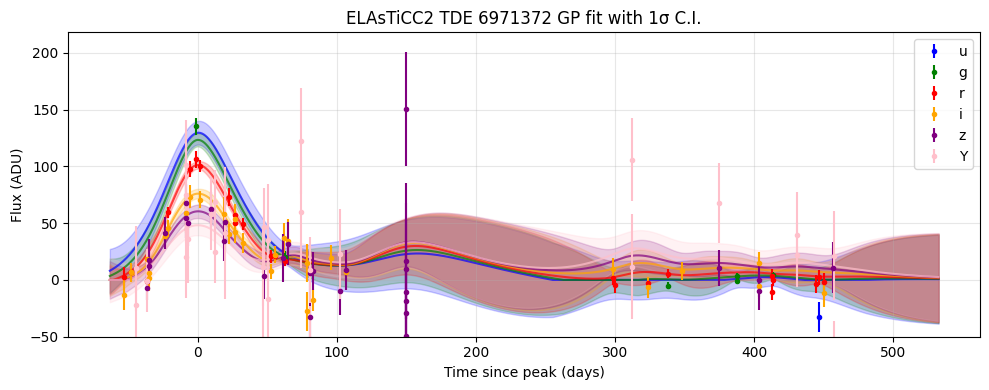

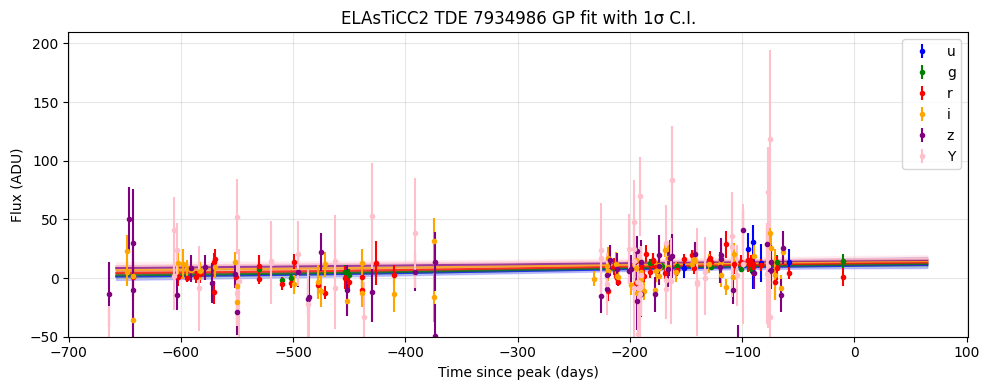

Linear fit failed for SNID 18210985: the number of data points must exceed order to scale the covariance matrix


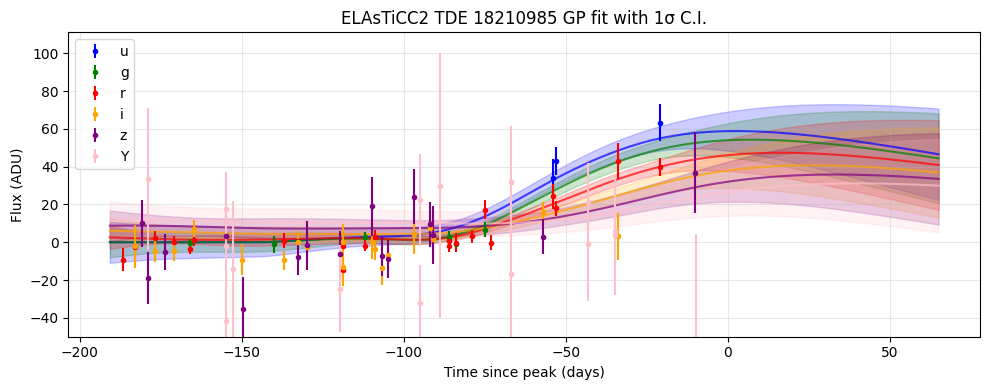

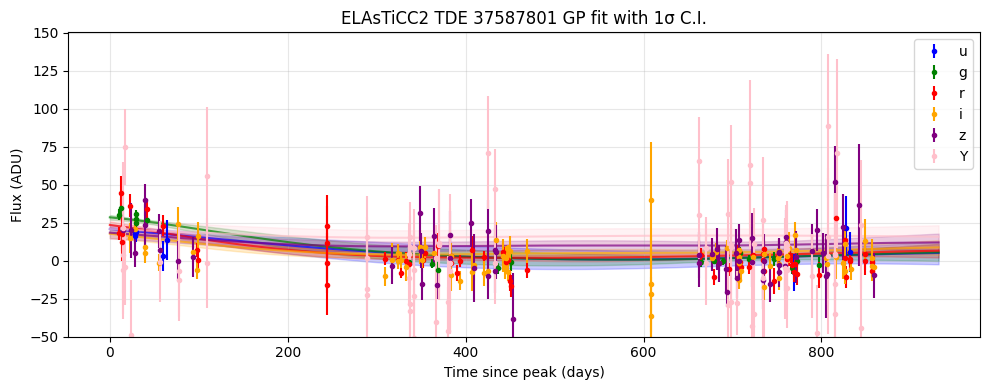

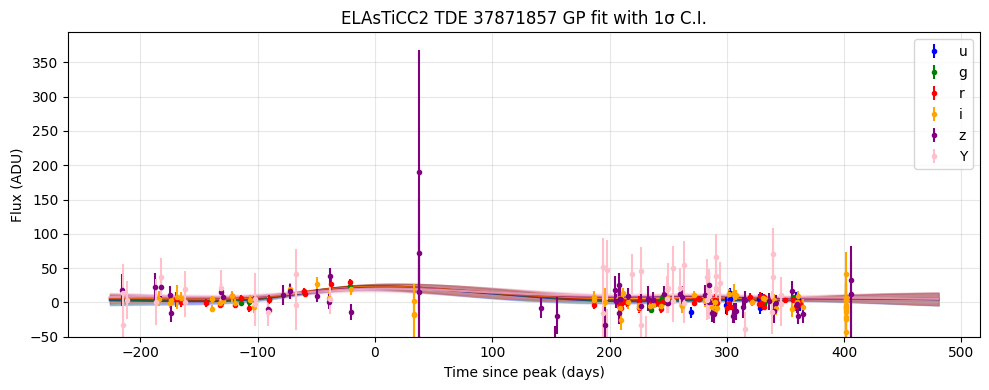

Linear fit failed for SNID 45149706: the number of data points must exceed order to scale the covariance matrix


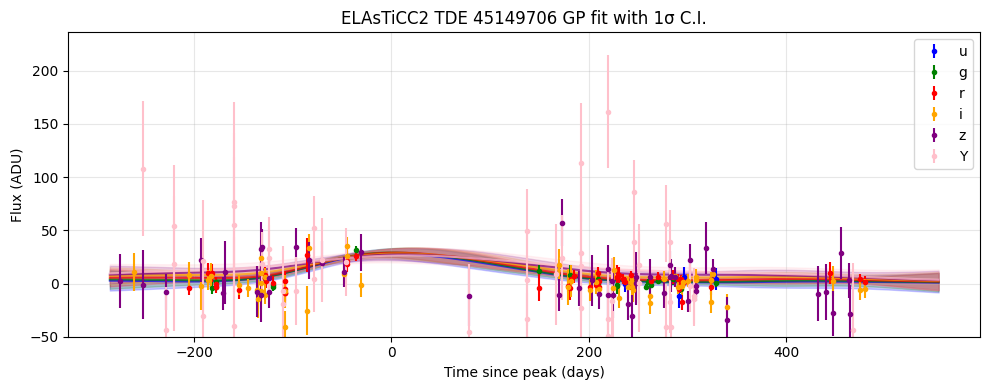

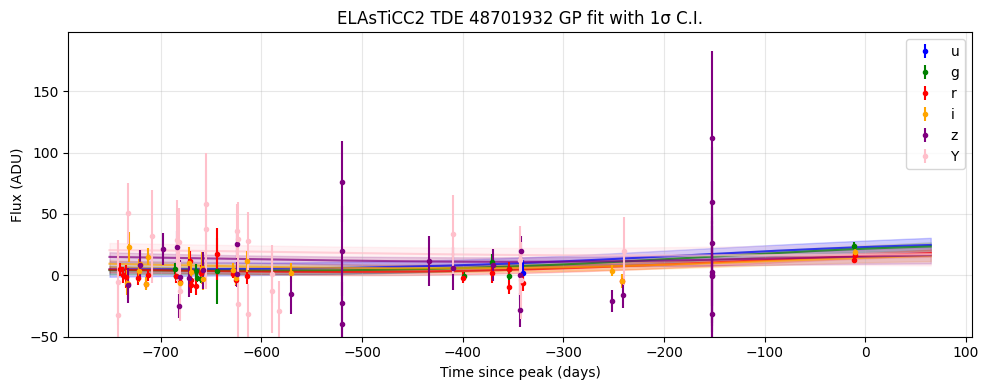

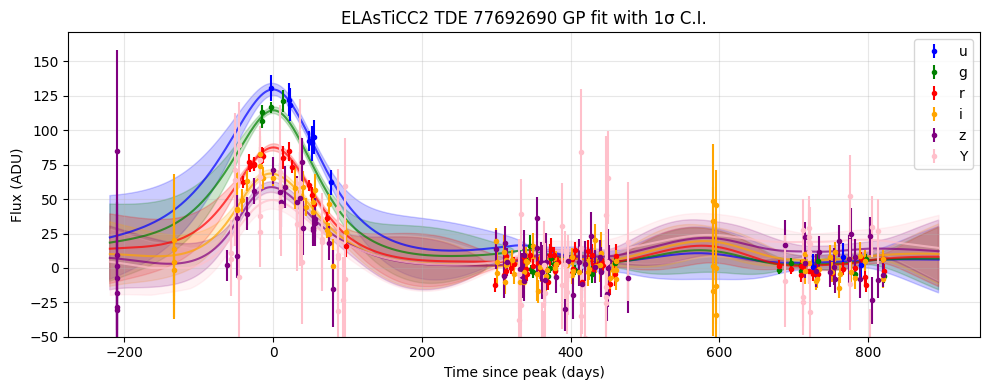

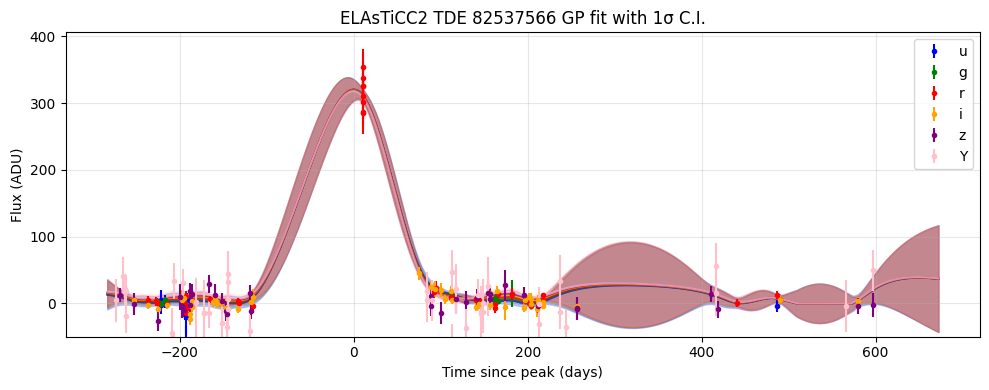

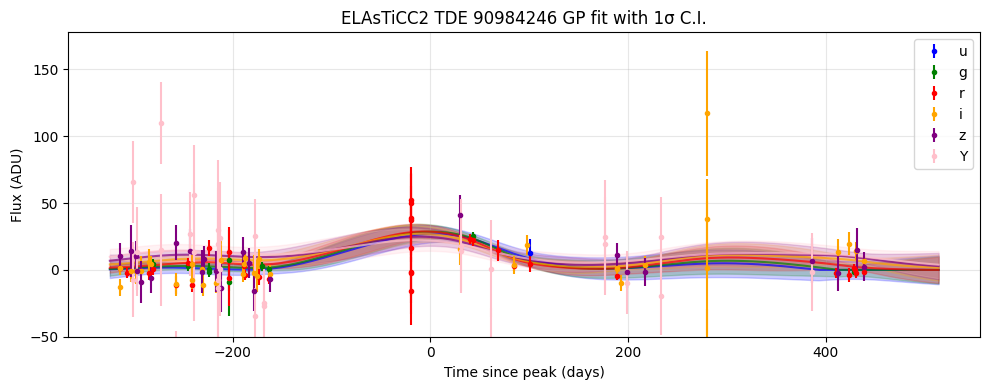

Linear fit failed for SNID 104070791: the number of data points must exceed order to scale the covariance matrix


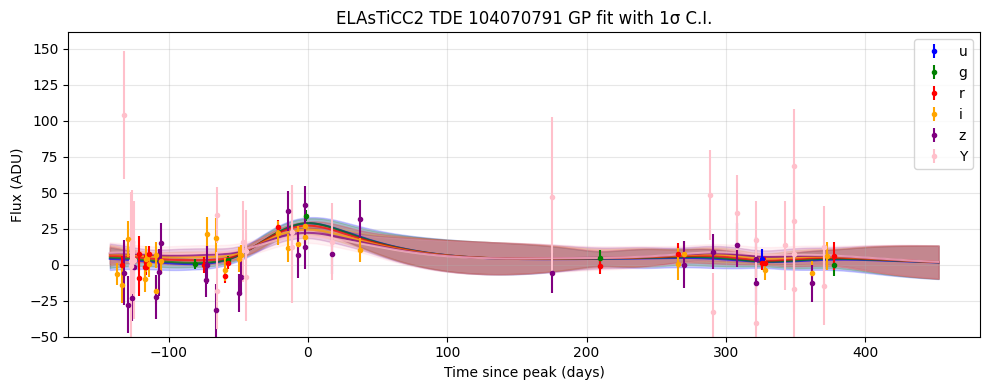

Linear fit failed for SNID 106809104: the number of data points must exceed order to scale the covariance matrix


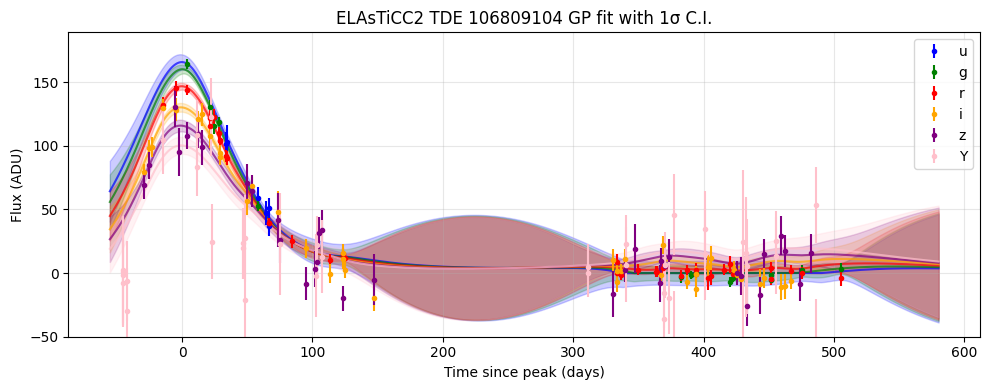

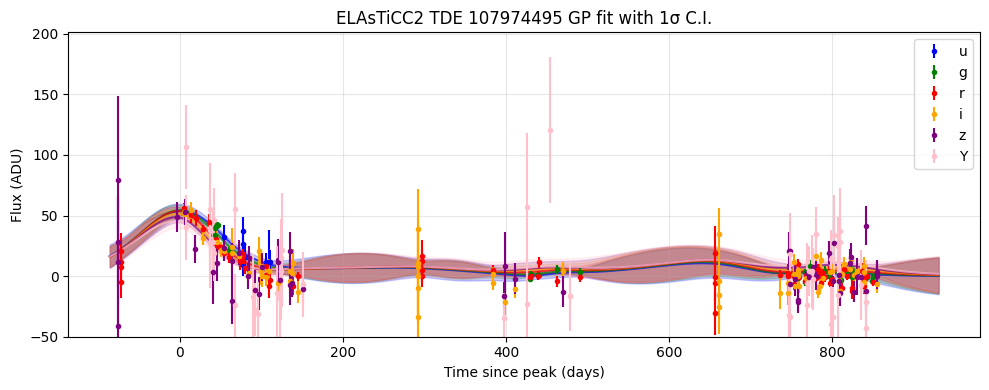

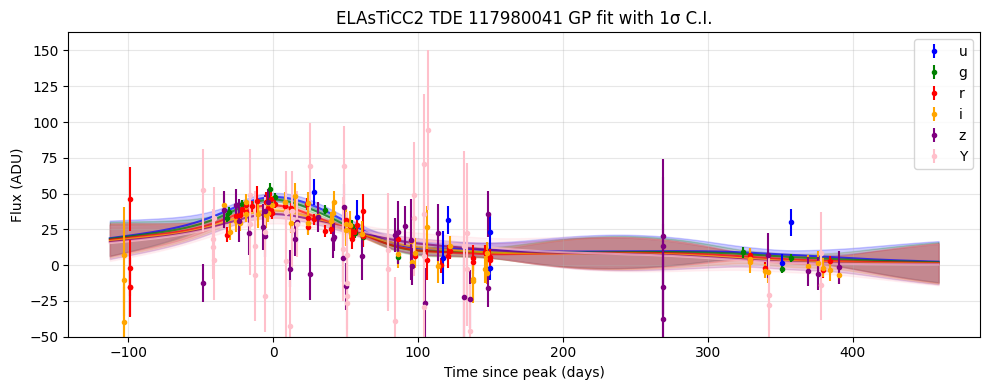

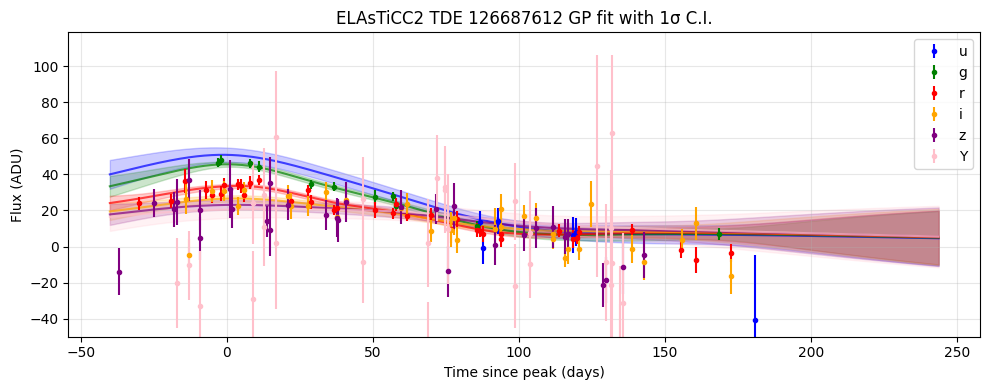

Saving figure for SNID 137495236 to home/bhardwaj/notebooksLSST/tdes-fzu/notebooksLSST/ELAsTiCC2_processed/results-images/SNID_137495236.png
Figure saved to home/bhardwaj/notebooksLSST/tdes-fzu/notebooksLSST/ELAsTiCC2_processed/results-images/SNID_137495236.png


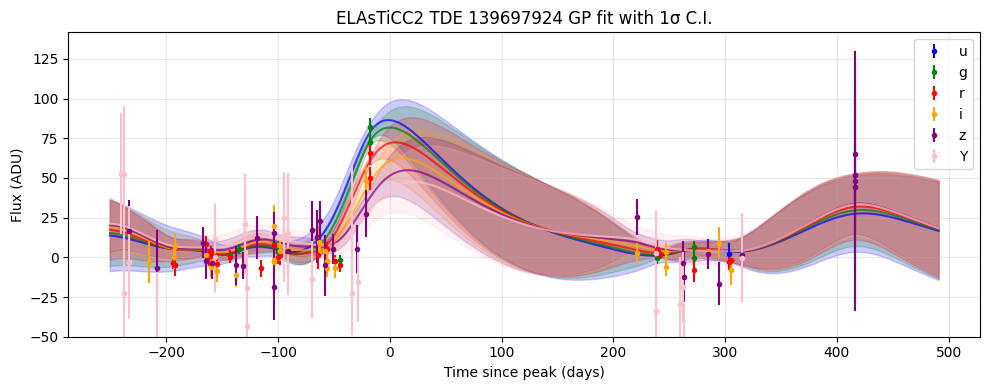

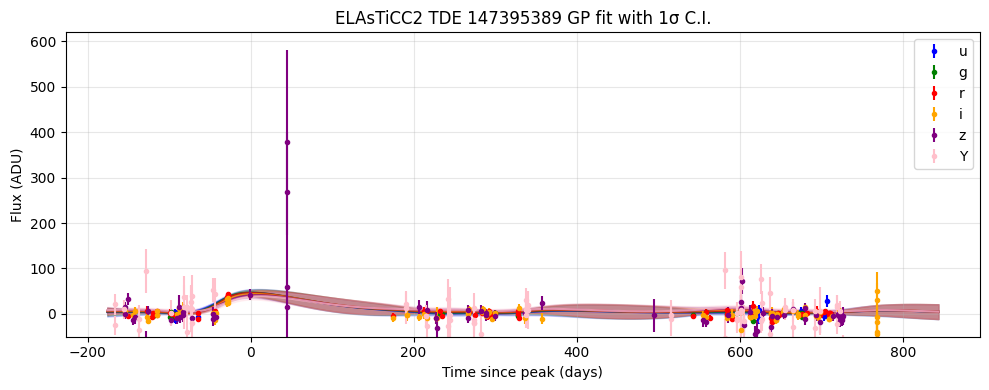

reading head file: ../../../karpov/ELASTICC2/ELASTICC2_FINAL_TDE/ELASTICC2_FINAL_NONIaMODEL0-0006_HEAD.FITS.gz


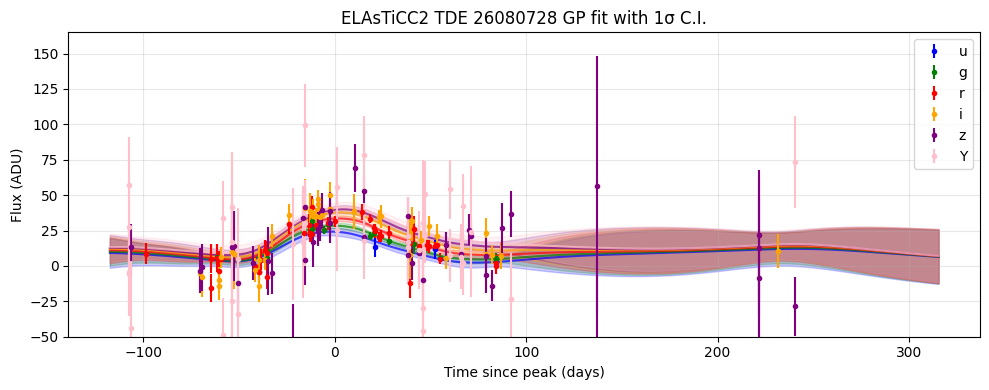

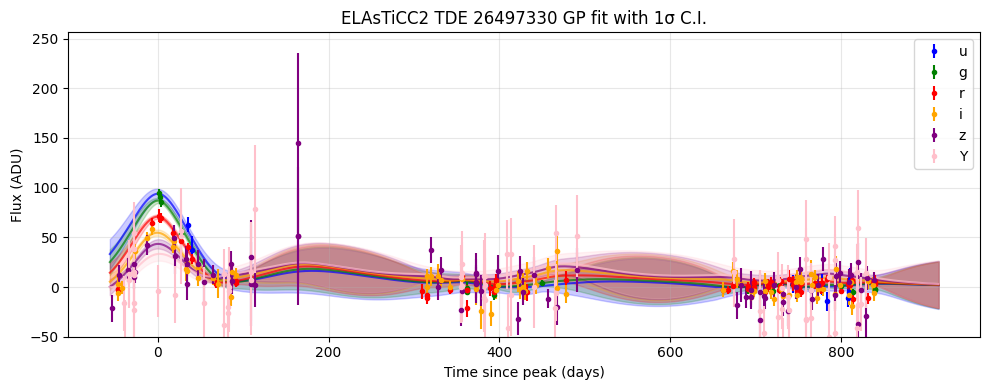

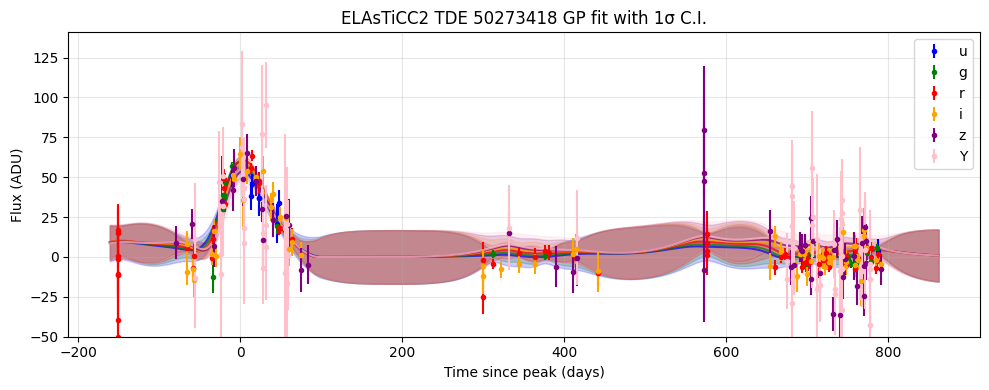

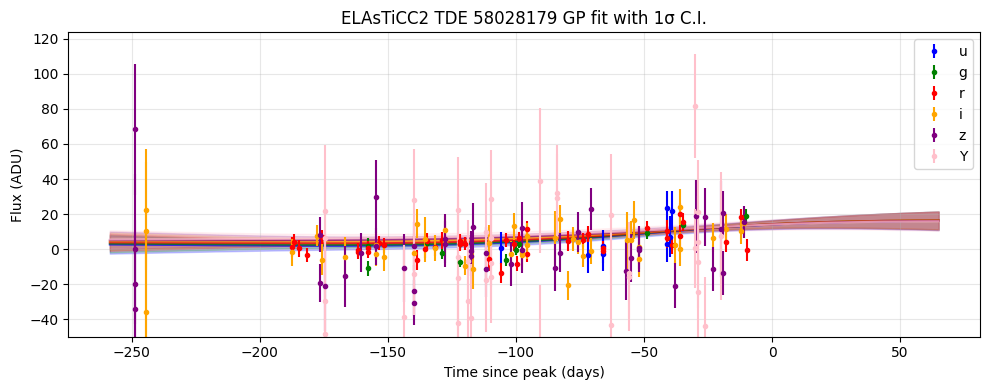

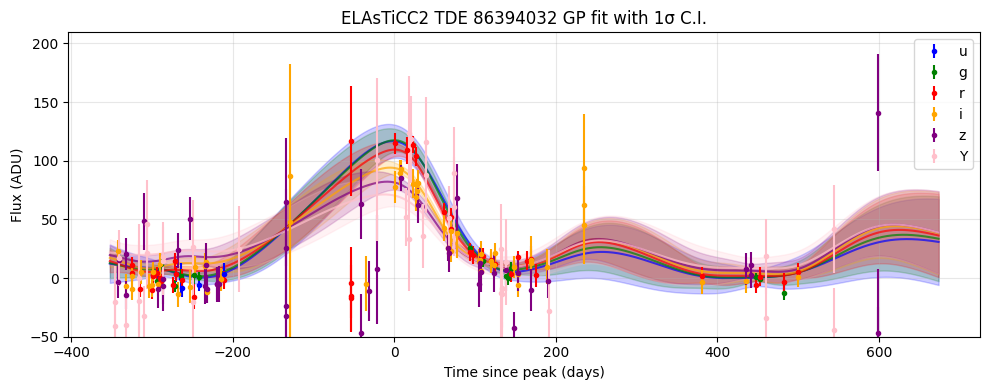

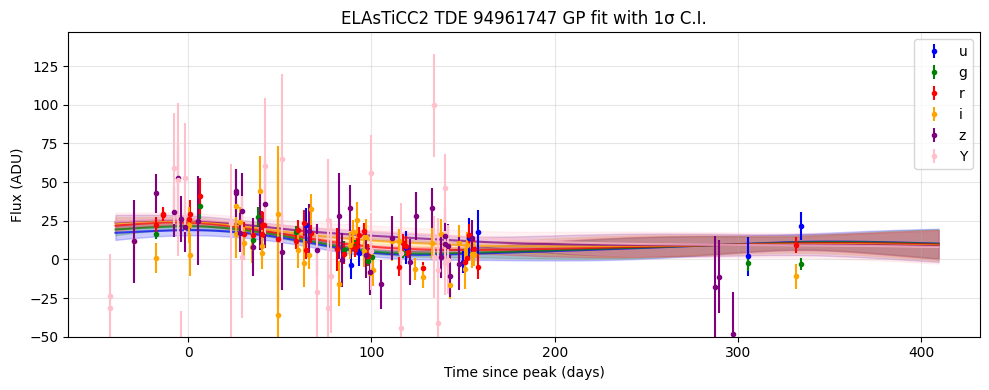

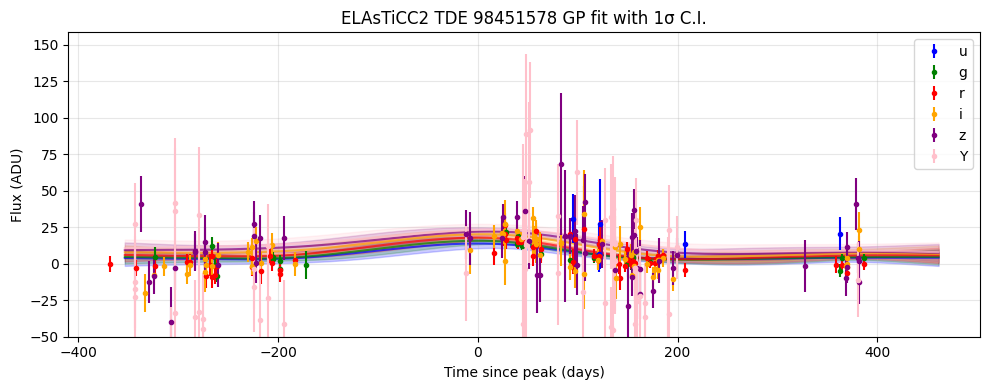

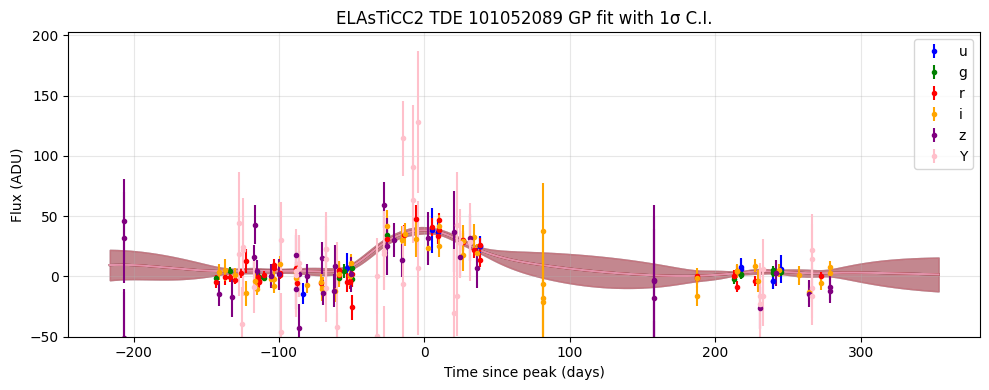

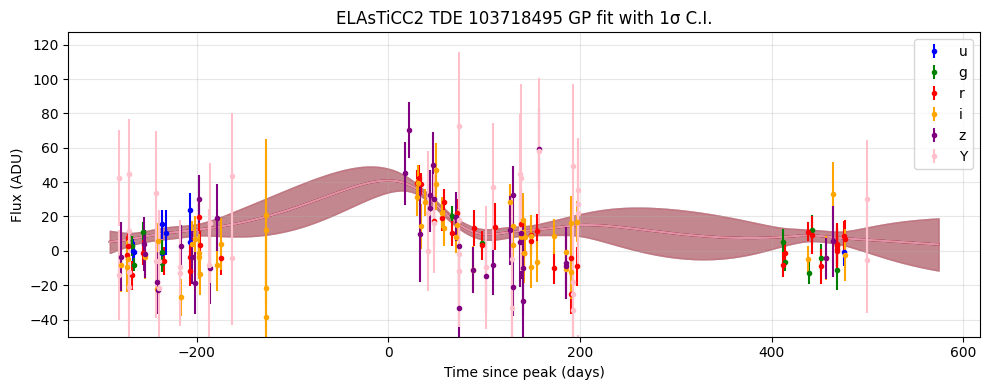

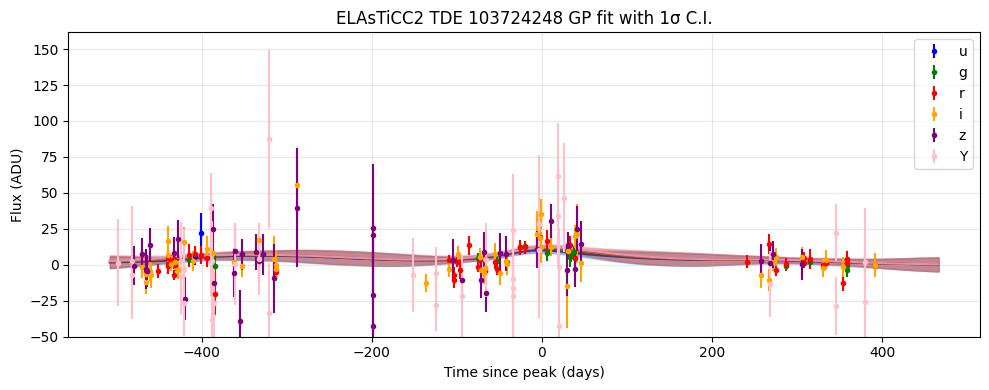

Saving figure for SNID 110044328 to home/bhardwaj/notebooksLSST/tdes-fzu/notebooksLSST/ELAsTiCC2_processed/results-images/SNID_110044328.png
Figure saved to home/bhardwaj/notebooksLSST/tdes-fzu/notebooksLSST/ELAsTiCC2_processed/results-images/SNID_110044328.png


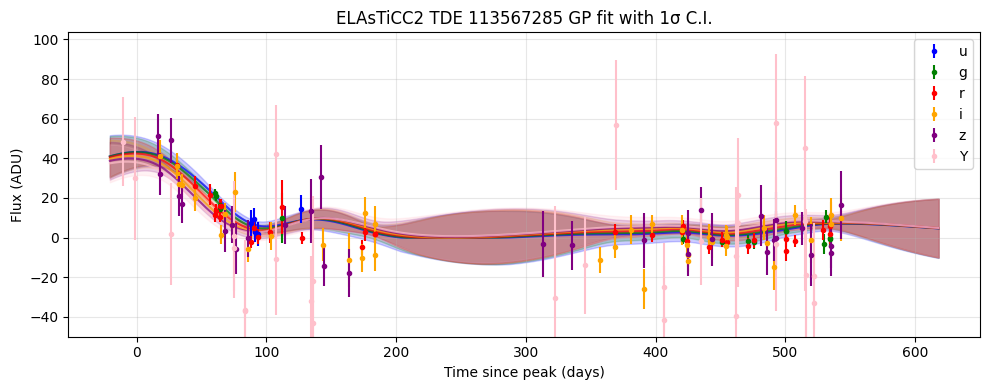

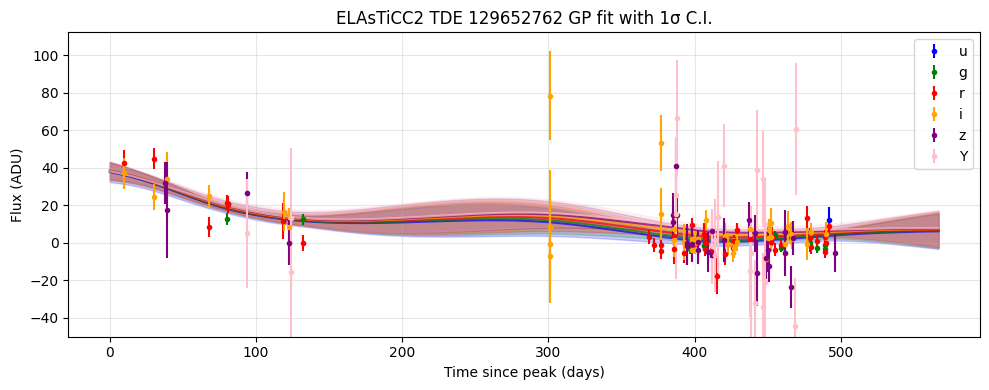

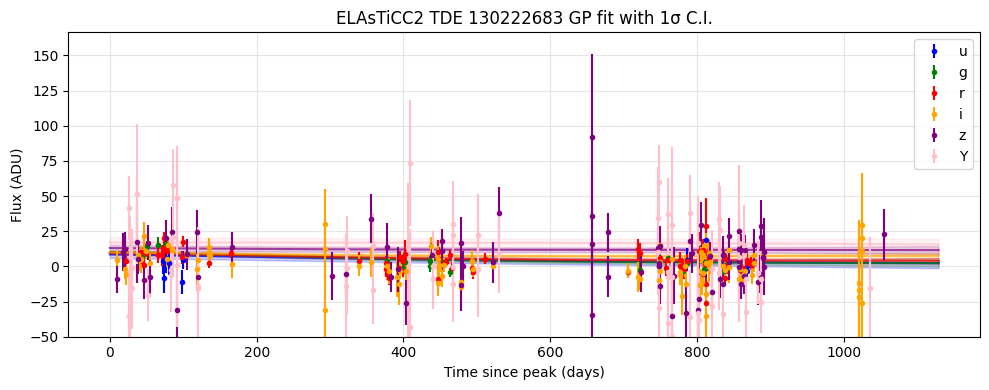

Linear fit failed for SNID 137708390: the number of data points must exceed order to scale the covariance matrix


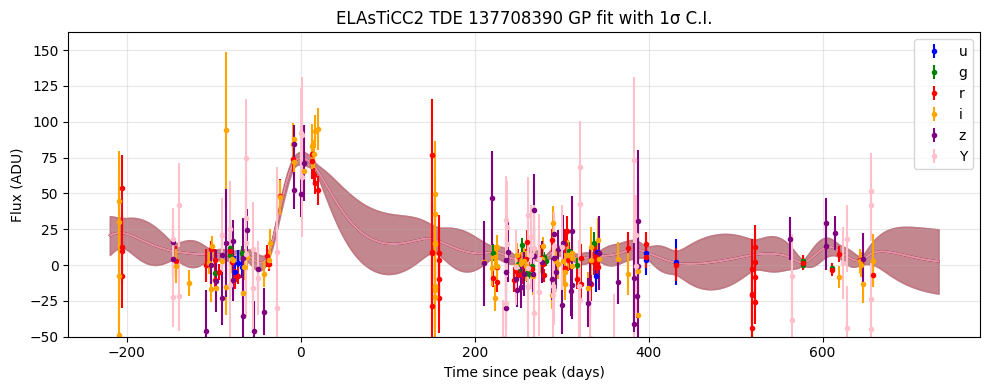

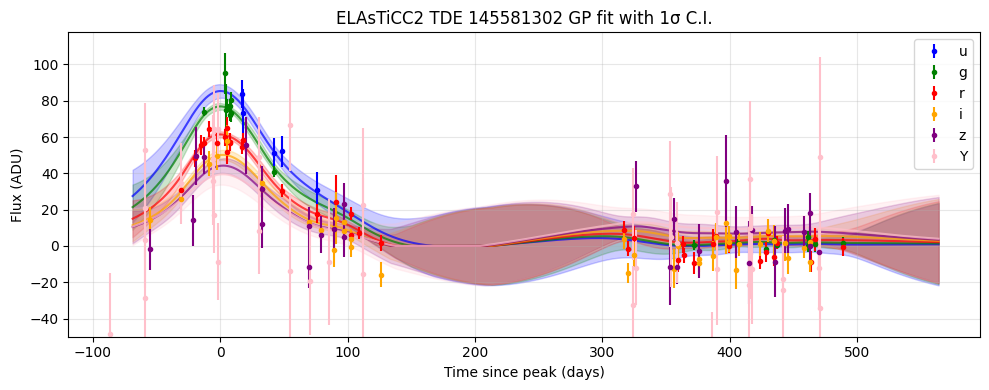

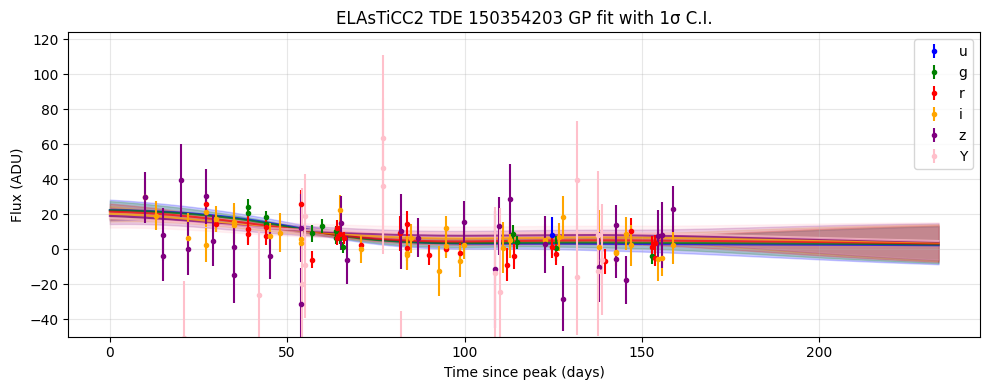

Time taken: 153629.65321922302 seconds


In [224]:
# True positives
# (Assuming 'true_positive_snids' is defined elsewhere in your code)

# Base path and template for file names
base_path = "../../../karpov/ELASTICC2/"
filename_template = "ELASTICC2_FINAL_{object_type}/ELASTICC2_FINAL_NONIaMODEL0-{index}_HEAD.FITS.gz"

# Object types and model names
object_info = [
    'TDE', #'AGN', 'SLSN-I+host', 'SLSN-I_no_host', 'SNIa-SALT3', 'SNIa-91bg',
    #'SNIax', 'SNIcBL+HostXT_V19', 'SNIb+HostXT_V19', 'SNIIn-MOSFIT', 'SNII-NMF',
    #'SNII+HostXT_V19', 'SNIIb+HostXT_V19', 'KN_B19', 'KN_K17'
]

# Generate all filenames and corresponding object types
all_filenames = []
object_types = []
for object_type in object_info:
    filenames = [os.path.join(base_path, filename_template.format(object_type=object_type, index=str(i).zfill(4))) for i in range(5, 7)]
    all_filenames.extend(filenames)
    object_types.extend([object_type] * len(filenames))

# Define the SNID(s) you want to save the figure for
save_snids = [137495236, 110044328]  # Replace with your specific SNID(s)

# Directory to save figures
save_directory = "home/bhardwaj/notebooksLSST/tdes-fzu/notebooksLSST/ELAsTiCC2_processed/results-images"
os.makedirs(save_directory, exist_ok=True)  # Create the directory if it doesn't exist

# Process files
for filename, object_type in zip(all_filenames, object_types):
    table, head = read_elasticc_file(filename)
    snids, shead_list, sub_list = get_snid_head_sub(table, head)

    for snid, shead, sub in zip(snids, shead_list, sub_list):
        snid = int(snid)  # Convert to standard integer

        # Check if the SNID is in the TP TDE list
        if snid not in true_positive_snids:
            continue  # Skip if not in TP TDE list

        # Compute GP for the data set of the SNID
        gp, flux, x, params = compute_gp(sub, shead)
        
        if gp is None:
            print(f"Skipping SNID {shead['SNID']} due to GP optimization failure.")
            continue  # Skip processing this SNID if GP failed

        # Calculate peak, rise, and fade times using the combined function
        rise_time, fade_time, t_peak, fpeak = peak_and_risefade(gp, x, flux)

        # Determine if the current SNID needs to have its figure saved
        if snid in save_snids:
            # Define the save path for this SNID
            save_path = os.path.join(save_directory, f"SNID_{snid}.png")
            show_plot = False  # Don't display the plot immediately
            print(f"Saving figure for SNID {snid} to {save_path}")
        else:
            save_path = None
            show_plot = True  # Display the plot normally

        # Plot using the modified calc_mean_colors_and_slope function
        fig, slope_pre_peak, slope_post_peak, slope_err_pre_peak, slope_err_post_peak = calc_mean_colors_and_slope(
            sub, shead, gp, 'g', 'r', object_type, snid, rise_time, fade_time, "GP fit with 1σ C.I.", t_peak,
            save_path=save_path,
            show_plot=show_plot
        )

        # If you want to further manipulate or close the figure after saving/showing
        if save_path is not None:
            plt.close(fig)  # Close the figure to free memory

# End the timer and print the elapsed time
end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")


reading head file: ../../../karpov/ELASTICC2/ELASTICC2_FINAL_TDE/ELASTICC2_FINAL_NONIaMODEL0-0002_HEAD.FITS.gz
reading head file: ../../../karpov/ELASTICC2/ELASTICC2_FINAL_AGN/ELASTICC2_FINAL_NONIaMODEL0-0002_HEAD.FITS.gz
Linear fit failed for SNID 1004456: the number of data points must exceed order to scale the covariance matrix


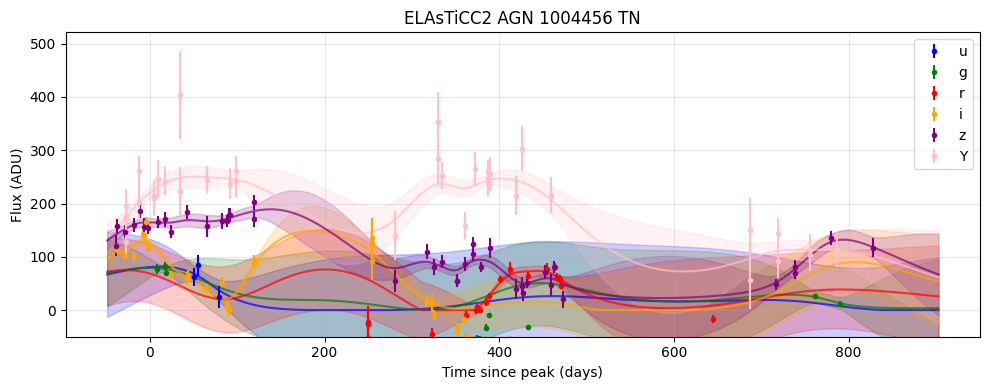

ValueError: too many values to unpack (expected 4)

In [375]:
#True negatives

# Base path and template for file names
base_path = "../../../karpov/ELASTICC2/"
filename_template = "ELASTICC2_FINAL_{object_type}/ELASTICC2_FINAL_NONIaMODEL0-{index}_HEAD.FITS.gz"

# Object types and model names
object_info = [
    'TDE', 'AGN', 'SLSN-I+host', 'SLSN-I_no_host', #'SNIa-SALT3', 
    'SNIa-91bg', 'SNIax', 'SNIcBL+HostXT_V19', 'SNIb+HostXT_V19', 'SNIIn-MOSFIT', 'SNII-NMF',
    'SNII+HostXT_V19', 'SNIIb+HostXT_V19', 'KN_B19', 'KN_K17'
]

# Generate all filenames and corresponding object types
all_filenames = []
object_types = []
for object_type in object_info:
    filenames = [os.path.join(base_path, filename_template.format(object_type=object_type, index=str(i).zfill(4))) for i in range(2, 3)]
    all_filenames.extend(filenames)
    object_types.extend([object_type] * len(filenames))

# Process files
for filename, object_type in zip(all_filenames, object_types):
    table, head = read_elasticc_file(filename)
    snids, shead_list, sub_list = get_snid_head_sub(table, head)

    for snid, shead, sub in zip(snids, shead_list, sub_list):
        snid = int(snid)  # Convert to standard integer

        # Check if the SNID is in the TN TDE list
        if snid not in true_negative_snids:
            continue  # Skip if not in TN TDE list

        # Compute GP for the data set of the SNID
        gp, flux, x, params = compute_gp(sub, shead)
        
        if gp is None:
            print(f"Skipping SNID {shead['SNID']} due to GP optimization failure.")
            continue  # Skip processing this SNID if GP failed

            
        # Calculate peak, rise, and fade times using the combined function
        rise_time, fade_time, t_peak, fpeak = peak_and_risefade(gp, x, flux)

        # Plot using the calc_mean_colors_and_slope function
        slope_pre_peak, slope_post_peak, slope_err_pre_peak, slope_err_post_peak = calc_mean_colors_and_slope(
            sub, shead, gp, 'g', 'r', object_type, snid, rise_time, fade_time, "TN", t_peak)

        plt.show()  # Display the plot immediately
        

# End the timer and print the elapsed time
end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")
